# Projeto Integração I

# Importação de Bibliotecas

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import shapely.wkt
import pyproj
from shapely.geometry import Point

# Importação do Data Frame

Identificamos que os dados a serem lidos estão em um arquivo .csv e usamos o método read_csv do pandas para passar os dados em um formato de DataFrame

In [112]:
data_location = "../Data/Real_State_Properati.csv"
df_prop = pd.read_csv(data_location, sep = '\t')


# Encontramos os tipos de cada coluna
Identificamos os tipos de cada coluna e printamos alguns dados para melhor entendimento dos dados

In [113]:
print(df_prop.dtypes)
df_prop.head()

property_type           object
place_name              object
country_name            object
state_name              object
lat                    float64
lon                    float64
price                  float64
currency                object
surface_total_in_m2    float64
dtype: object


property_type place_name country_name       state_name        lat  \
0            PH  Mataderos    Argentina  Capital Federal -34.661824   
1     apartment  Mataderos    Argentina  Capital Federal -34.652262   
2     apartment   Belgrano    Argentina  Capital Federal -34.559873   
3     apartment   Belgrano    Argentina  Capital Federal -34.559873   
4            PH  Mataderos    Argentina  Capital Federal -34.652356   

         lon     price currency  surface_total_in_m2  
0 -58.508839   62000.0      USD                 55.0  
1 -58.522982   72000.0      USD                 55.0  
2 -58.443362  138000.0      USD                 45.0  
3 -58.443362  195000.0      USD                 65.0  
4 -58.501624  239000.0      USD                140.0

# Verificando quantidade de linhas do arquivo

In [114]:
df_prop.shape[0]

17223

# Modificando nome da coluna surface_total_in_m2 para total_m2
Facilitará quando precisarmos analisar e usar esse campo

In [115]:
df_prop.rename(columns={'surface_total_in_m2': 'total_m2'}, inplace = True)
df_prop.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'price', 'currency', 'total_m2'],
      dtype='object')

# Verificação de valores ausentes
Verificamos os valores ausentes em cada coluna. Conclusão: Não existem valores ausentes em nenhuma das colunas

In [116]:
data_null = df_prop.apply(lambda x : x.isnull().sum())
data_null

property_type    0
place_name       0
country_name     0
state_name       0
lat              0
lon              0
price            0
currency         0
total_m2         0
dtype: int64

# Verificação de valores menores ou iguais a zero nas colunas price e total_m2
Vamos verificar se existem valores menores ou iguais a zero nas colunas price e surface_total_in_m2. Sobre a coluna price não encontramos nenhum registro com valor menor ou igual a zero, mas sobre a coluna total_m2 encontramos 6 registros.

In [117]:
data_menor_igual_zero = pd.DataFrame(df_prop, columns=['price','total_m2'])
data_menor_igual_zero = data_menor_igual_zero.apply(lambda x : x<=0).sum()
data_menor_igual_zero

price       0
total_m2    6
dtype: int64

# Verificando quais registros de total_m2 estão com valor menor ou igual a zero
Temos 6 registros com valor em total_m2 menor ou igual a zero. Nas próximas linhas veremos qual ação tomar diante desse fato.

In [118]:
mask_m2_menor_igual_zero = df_prop['total_m2']<=0
data_m2_menor_igual_zero = df_prop.loc[mask_m2_menor_igual_zero]
data_m2_menor_igual_zero

property_type         place_name country_name       state_name  \
2486      apartment       Palermo Soho    Argentina  Capital Federal   
4872      apartment           Recoleta    Argentina  Capital Federal   
5454      apartment          Caballito    Argentina  Capital Federal   
6318      apartment  Palermo Hollywood    Argentina  Capital Federal   
7170      apartment           Barracas    Argentina  Capital Federal   
15888     apartment       Barrio Norte    Argentina  Capital Federal   

             lat        lon     price currency  total_m2  
2486  -34.589974 -58.425614  780000.0      USD       0.0  
4872  -34.588818 -58.390648  320000.0      USD       0.0  
5454  -34.617348 -58.449404   68500.0      USD       0.0  
6318  -34.582558 -58.432585  175000.0      USD       0.0  
7170  -34.641131 -58.369122  135000.0      USD       0.0  
15888 -34.598727 -58.395851  112000.0      USD       0.0

# Vamos preencher o total_m2 usando a média por property_type e place_name
Primeiro iremos criar um novo dataframe apenas com os registros cujo total_m2 seja maior que zero. Depois disso aplicaremos a média de total_m2 por property_type e place_name e preencheremos os valores faltantes na coluna total_m2 com a média respectiva por property_name e place_name

In [119]:
mask_m2_maior_zero = df_prop['total_m2']>0
data_m2_maior_zero = df_prop.loc[mask_m2_maior_zero]
data_m2_maior_zero = pd.DataFrame(data_m2_maior_zero, columns=['property_type','place_name','total_m2'])
data_m2_maior_zero

property_type     place_name  total_m2
0                PH      Mataderos      55.0
1         apartment      Mataderos      55.0
2         apartment       Belgrano      45.0
3         apartment       Belgrano      65.0
4                PH      Mataderos     140.0
...             ...            ...       ...
17218     apartment   Barrio Norte      91.0
17219     apartment       Recoleta      44.0
17220     apartment       Belgrano     157.0
17221     apartment       Belgrano     157.0
17222     apartment  Villa Urquiza      46.0

[17217 rows x 3 columns]

# Agrupando as médias de total_m2 por property_type e place_name

In [120]:
data_media_m2_pp = data_m2_maior_zero.groupby(['property_type','place_name']).mean().reset_index()
data_media_m2_pp

property_type        place_name     total_m2
0              PH            Abasto   116.100000
1              PH         Agronomía   123.333333
2              PH           Almagro   149.529412
3              PH         Balvanera   149.153846
4              PH          Barracas   161.142857
..            ...               ...          ...
224         store     Villa Ortuzar   386.500000
225         store        Villa Real   520.000000
226         store     Villa Soldati  9505.500000
227         store     Villa Urquiza   125.500000
228         store  Villa del Parque   272.500000

[229 rows x 3 columns]

# Atribuindo as médias de total_m2 agrupadas nas respectivas linhas respeitando property_type e place_name
Usando laço for para atualizar a média do total_m2 por property_type e place_name e depois realizando um check para confirmar que não exista nenhum registro com o total_m2 menor ou igual a zero.

In [121]:
for i in df_prop[mask_m2_menor_igual_zero].index:
    property_type = df_prop.loc[i, 'property_type']
    place_name    = df_prop.loc[i, 'place_name']
    total_m2      = float(data_media_m2_pp[(data_media_m2_pp['property_type']==property_type) & (data_media_m2_pp['place_name']==place_name)]['total_m2'])
    df_prop.loc[i, 'total_m2'] = total_m2

# Verificando se sobrou algum registro com total_m2 menor ou igual a zero

In [122]:
mask_m2_menor_igual_zero_check = df_prop['total_m2']<=0
data_m2_menor_igual_zero_check = df_prop.loc[mask_m2_menor_igual_zero_check]
data_m2_menor_igual_zero_check

Empty DataFrame
Columns: [property_type, place_name, country_name, state_name, lat, lon, price, currency, total_m2]
Index: []

# Verificando número de registrospor property_type

In [123]:
df_prop.value_counts('property_type')

property_type
apartment    14428
PH            1142
house          888
store          765
dtype: int64

# Verificando número de registros por currency
Percebemos que existem registros em dólares e em pesos argentinos. Teremos que converter tudo a uma moeda só

In [124]:
df_prop.value_counts('currency')

currency
USD    16700
ARS      523
dtype: int64

# Criando coluna para unificação de preços uma vez que temos preços em Pesos e Dólares. Cotação do Dólar em 118.44 22/05/2022

In [125]:
df_prop['price_usd'] = df_prop.apply(lambda x: x['price']/1 if x['currency']=='USD' else x['price']/118.44, axis=1)
df_prop.head(10)

property_type   place_name country_name       state_name        lat  \
0            PH    Mataderos    Argentina  Capital Federal -34.661824   
1     apartment    Mataderos    Argentina  Capital Federal -34.652262   
2     apartment     Belgrano    Argentina  Capital Federal -34.559873   
3     apartment     Belgrano    Argentina  Capital Federal -34.559873   
4            PH    Mataderos    Argentina  Capital Federal -34.652356   
5     apartment      Palermo    Argentina  Capital Federal -34.580504   
6     apartment      Palermo    Argentina  Capital Federal -34.590926   
7     apartment       Flores    Argentina  Capital Federal -34.635118   
8     apartment        Boedo    Argentina  Capital Federal -34.621769   
9     apartment  Las Cañitas    Argentina  Capital Federal -34.571150   

         lon     price currency  total_m2  price_usd  
0 -58.508839   62000.0      USD      55.0    62000.0  
1 -58.522982   72000.0      USD      55.0    72000.0  
2 -58.443362  138000.0      USD      45.0   138000.0  
3 -58.443362  195000.0      USD      65.0   195000.0  
4 -58.501624  239000.0      USD     140.0   239000.0  
5 -58.405874  350000.0      USD     104.0   350000.0  
6 -58.411665  270500.0      USD     118.0   270500.0  
7 -58.473964   75000.0      USD      43.0    75000.0  
8 -58.422108  145000.0      USD      80.0   145000.0  
9 -58.423297  480000.0      USD     220.0   480000.0

In [126]:
# substituindo todas as moedas pesos pos dolar em currency
df_prop = df_prop.replace({'currency': 'ARS'}, 'USD')
df_prop.value_counts('currency')

currency
USD    17223
dtype: int64

# Verificando quantos registros existem por place_name

In [127]:
df_prop.value_counts('place_name')

place_name
Palermo            1502
Belgrano           1496
Caballito          1389
Recoleta           1001
Flores              893
                   ... 
Parque Chas          15
Palermo Viejo        10
Villa Soldati         7
Villa Riachuelo       3
Catalinas             1
Length: 62, dtype: int64

# Criação de uma coluna price_m2 que armazenará o preço em dólar por m2
Decidimos criar uma coluna para armazenar o preço em dólar por m2. Fizemos isso porque entendemos que 3 variáveis influenciam o preço, property_type, place_name e total_m2. Criando a coluna price_m2 entendemos que teremos somente 2 variáveis influenciando o price_m2, property_type e place_name. Temos todos os valores preenchidos na coluna divisora total_m2.

In [128]:
df_prop['price_m2'] = df_prop.apply(lambda x: x['price_usd'] / x['total_m2'], axis=1)
df_prop.head(5)

property_type place_name country_name       state_name        lat  \
0            PH  Mataderos    Argentina  Capital Federal -34.661824   
1     apartment  Mataderos    Argentina  Capital Federal -34.652262   
2     apartment   Belgrano    Argentina  Capital Federal -34.559873   
3     apartment   Belgrano    Argentina  Capital Federal -34.559873   
4            PH  Mataderos    Argentina  Capital Federal -34.652356   

         lon     price currency  total_m2  price_usd     price_m2  
0 -58.508839   62000.0      USD      55.0    62000.0  1127.272727  
1 -58.522982   72000.0      USD      55.0    72000.0  1309.090909  
2 -58.443362  138000.0      USD      45.0   138000.0  3066.666667  
3 -58.443362  195000.0      USD      65.0   195000.0  3000.000000  
4 -58.501624  239000.0      USD     140.0   239000.0  1707.142857

# Verificando se foi preenchido price_m2 com valor menor ou igual a zero

In [129]:
mask_price_m2_menor_igual_zero = df_prop['price_m2']<= 0
data_price_m2_menor_igual_zero = df_prop.loc[mask_price_m2_menor_igual_zero]
data_price_m2_menor_igual_zero

Empty DataFrame
Columns: [property_type, place_name, country_name, state_name, lat, lon, price, currency, total_m2, price_usd, price_m2]
Index: []

# Observando o DataFrame
Podemos perceber pelos valores máximos e mínimos das colunas total_m2, price_usd e price_m2 que temos uma variação muito grande de valores. Possivelmente temos outliers nessas colunas.

In [130]:
df_prop.describe()

lat           lon         price       total_m2     price_usd  \
count  17223.000000  17223.000000  1.722300e+04   17223.000000  1.722300e+04   
mean     -34.600541    -58.434354  3.567353e+05     118.019274  2.653732e+05   
std        0.039048      0.055797  1.183132e+06    1534.548066  5.197347e+05   
min      -38.416097    -63.616672  5.500000e+03      10.000000  7.514353e+02   
25%      -34.620026    -58.463026  1.080000e+05      44.000000  1.010500e+05   
50%      -34.600937    -58.434584  1.634760e+05      66.000000  1.550000e+05   
75%      -34.581559    -58.402708  3.000000e+05     116.000000  2.750000e+05   
max      -34.535096    -58.354956  5.000000e+07  200000.000000  4.654544e+07   

            price_m2  
count   17223.000000  
mean     2679.211799  
std      2622.361066  
min         6.014258  
25%      1866.666667  
50%      2365.853659  
75%      2950.000000  
max    206333.333333

# Verificando os 50 registros com maior price_m2
Ordenamos os registros por price_m2 do maior para o menor e verificamos os registros. Aparentemente o registro de index 3901 é um outlier pois está muito distante do segundo maior. Observamos que existem imóveis com total_m2=10, aparentemente esses são valores errados e iremos eliminar do dataframe. Se olharmos a relação abaixo concluíremos que os tipos de imóveis mais caros são apartamentos e se concentram nos bairros de Boedo, Flores, San Cristobal, Almagro. O bairro Palermo possui dois imóveis entre os 5 valores mais caros por m2 porém os dois imóveis estão com 10m2 cada um e iremos eliminar esses registros.

In [131]:
df_prop.sort_values(by='price_m2', ascending=False)[['place_name','price_m2','total_m2','property_type']].head(50)

place_name       price_m2  total_m2 property_type
3901                  Boedo  206333.333333      33.0     apartment
15398               Palermo   44900.000000      10.0     apartment
15399               Palermo   43640.000000      10.0     apartment
9292                 Flores   40720.405797      69.0     apartment
9293                 Flores   39899.594595      37.0     apartment
3649                 Flores   35783.783784      37.0     apartment
3683               Saavedra   35591.836735      49.0     apartment
3678                  Boedo   34534.482759      58.0     apartment
3020               Recoleta   33000.000000      10.0     apartment
3647                  Boedo   32486.486486      37.0     apartment
3641   Centro / Microcentro   31250.000000      40.0     apartment
3703               Barracas   29562.500000      48.0     apartment
3796          San Cristobal   25196.842105      38.0     apartment
924                Saavedra   25000.000000      10.0            PH
3656                Palermo   24574.000000      50.0     apartment
3808               Saavedra   24512.026316      38.0     apartment
3943                Almagro   24387.804878      41.0     apartment
3855                  Boedo   24375.000000      32.0     apartment
3876                  Boedo   24375.000000      32.0     apartment
3797                  Boedo   24189.333333      30.0     apartment
3806                  Boedo   24180.033333      30.0     apartment
3803                  Boedo   24145.000000      40.0     apartment
3939          San Cristobal   24097.560976      41.0     apartment
3937          San Cristobal   24073.170732      41.0     apartment
3875                Almagro   23815.151515      33.0     apartment
3895                Almagro   23815.151515      33.0     apartment
3854                Almagro   23815.151515      33.0     apartment
3945          San Cristobal   23500.000000      42.0     apartment
3873                Almagro   23226.470588      34.0     apartment
3852                Almagro   23226.470588      34.0     apartment
3930                  Boedo   23225.806452      31.0     apartment
3929                Almagro   23064.516129      31.0         house
2418                   Once   22000.000000      50.0         store
3962               Congreso   21973.684211      38.0     apartment
3807                   Boca   21956.700000      30.0     apartment
3879                  Boedo   21935.483871      31.0     apartment
3898                  Boedo   21935.483871      31.0     apartment
3860                  Boedo   21935.483871      31.0     apartment
3942                Almagro   21926.829268      41.0     apartment
3846                Almagro   21900.000000      31.0     apartment
3952                  Boedo   21580.645161      31.0     apartment
3924                  Boedo   21250.000000      32.0     apartment
3802                  Boedo   21085.933333      30.0     apartment
3931                  Boedo   21000.000000      35.0     apartment
3902                Almagro   20936.363636      33.0     apartment
3946                  Boedo   20831.250000      32.0     apartment
3847                  Boedo   20784.210526      38.0         house
3869                  Boedo   20784.210526      38.0         house
3947                  Boedo   20781.250000      32.0     apartment
3944                  Boedo   20781.250000      32.0     apartment

# Eliminando registro de index 3901 - outlier de price_m2 muito elevado

In [132]:
df_prop = df_prop.drop(3901)

# Verificando imóveis menores ou iguais a 10m2
O único registro que nos gerou dúvida em eliminar é o do tipo store porque Flores é um bairro valorizado e nos pareceu que existe a possibilidade de existir uma loja de 10m2 em um bairro valorizado.

In [133]:
mask_total_m2_menor_igual_10 = df_prop.total_m2 <= 10
df_prop.loc[mask_total_m2_menor_igual_10]

property_type place_name country_name       state_name        lat  \
924              PH   Saavedra    Argentina  Capital Federal -34.555993   
3020      apartment   Recoleta    Argentina  Capital Federal -34.593267   
7646          store     Flores    Argentina  Capital Federal -34.640585   
15365     apartment      Nuñez    Argentina  Capital Federal -34.554224   
15398     apartment    Palermo    Argentina  Capital Federal -34.583276   
15399     apartment    Palermo    Argentina  Capital Federal -34.583276   

             lon     price currency  total_m2  price_usd  price_m2  
924   -58.477914  250000.0      USD      10.0   250000.0   25000.0  
3020  -58.412733  330000.0      USD      10.0   330000.0   33000.0  
7646  -58.456329   25000.0      USD      10.0    25000.0    2500.0  
15365 -58.467834  157350.0      USD      10.0   157350.0   15735.0  
15398 -58.426027  449000.0      USD      10.0   449000.0   44900.0  
15399 -58.426027  436400.0      USD      10.0   436400.0   43640.0

# Eliminado registros com total_m2 menor ou igual a 10
O único registro que ficará com 10m2 é o da loja.

In [134]:
mask_total_m2_menor_igual_10 = (df_prop.total_m2 <= 10) & (df_prop.property_type != 'store')

df_prop = df_prop.drop(df_prop[mask_total_m2_menor_igual_10].index)

mask_total_m2_menor_igual_10 = df_prop.total_m2 <= 10

df_prop.loc[mask_total_m2_menor_igual_10]

property_type place_name country_name       state_name        lat  \
7646         store     Flores    Argentina  Capital Federal -34.640585   

            lon    price currency  total_m2  price_usd  price_m2  
7646 -58.456329  25000.0      USD      10.0    25000.0    2500.0

# Aparentemente ainda existem muitos valores outliers na variável price_m2.

<AxesSubplot:xlabel='price_m2'>

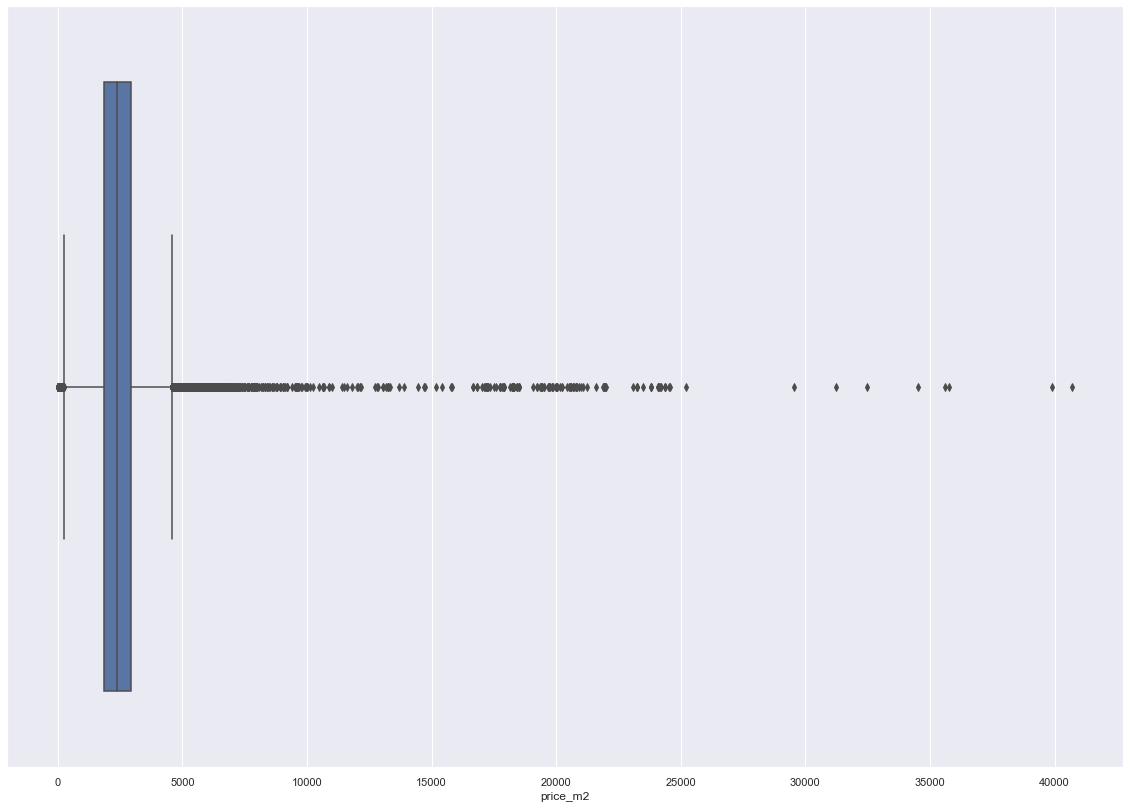

In [135]:
sns.boxplot(x='price_m2', data=df_prop, orient='h')

# Criando nova coluna concatenando property e place para analisar em boxplot

In [136]:
df_prop['property_place'] = df_prop['property_type'] + '_' + df_prop['place_name']

# Verificando outliers do tipo apartamento

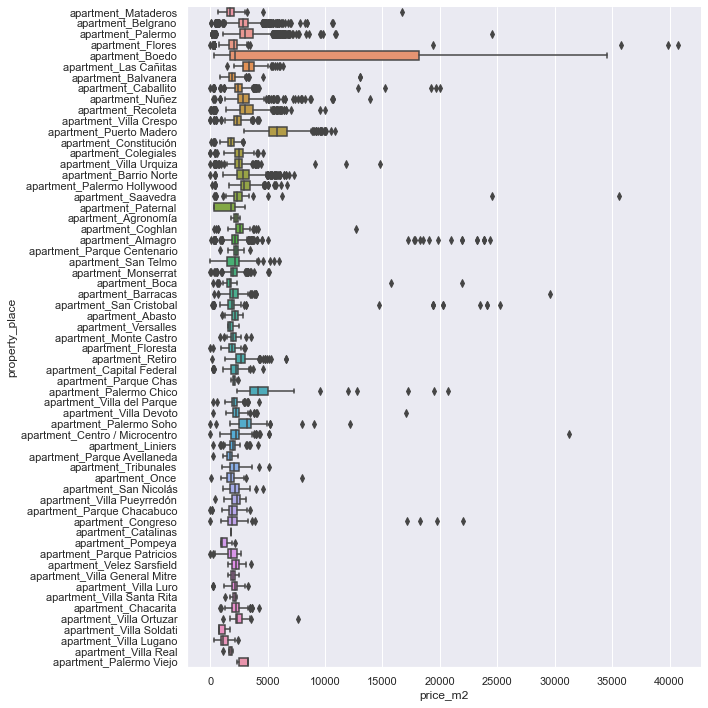

In [137]:
sns.catplot(y="property_place", x="price_m2",
                data=df_prop[df_prop['property_type']=='apartment'], kind="box",
                height=10, orient='h');

# Verificando outliers do tipo PH

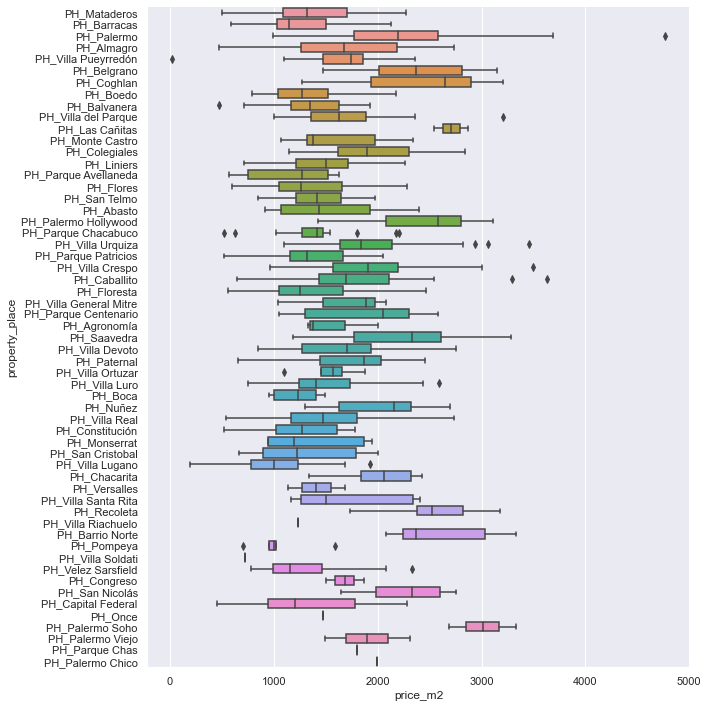

In [138]:
sns.catplot(y="property_place", x="price_m2",
                data=df_prop[df_prop['property_type']=='PH'], kind="box",
                height=10, orient='h');

# Verificando outliers do tipo store

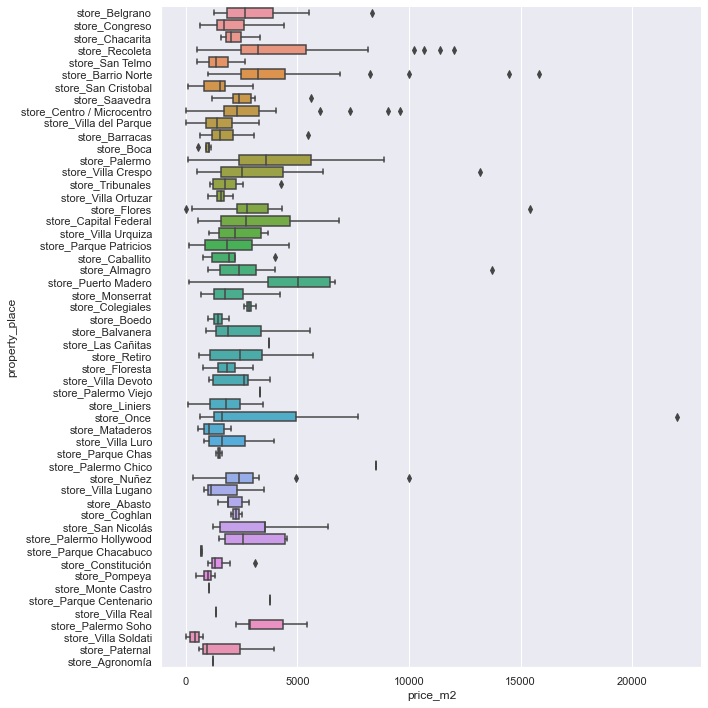

In [139]:
sns.catplot(y="property_place", x="price_m2",
                data=df_prop[df_prop['property_type']=='store'], kind="box",
                height=10, orient='h');

# Verificando outliers do tipo house

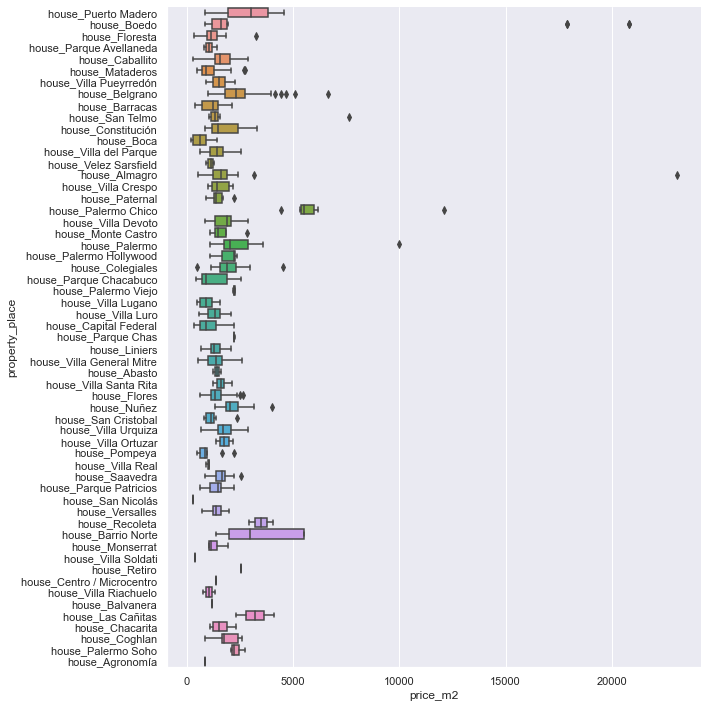

In [140]:
sns.catplot(y="property_place", x="price_m2",
                data=df_prop[df_prop['property_type']=='house'], kind="box",
                height=10, orient='h');

# Criando novo DataFrame agrupando place_name e property_type
Usaremos esse DataFrame para correr os registros de cada bairro buscando o valor de price_m2 desde 25 % abaixo do primeiro e até 25% acima do terceiro quartil. Manteremos somente os dados nesse intervalo.

In [141]:
df_prop2 = pd.DataFrame(df_prop, columns=['property_type','place_name','property_place','price_m2'])
df_prop2 = df_prop2.groupby(['property_type','place_name','property_place']).count().reset_index()
df_prop2

property_type        place_name          property_place  price_m2
0              PH            Abasto               PH_Abasto        10
1              PH         Agronomía            PH_Agronomía         3
2              PH           Almagro              PH_Almagro        51
3              PH         Balvanera            PH_Balvanera        26
4              PH          Barracas             PH_Barracas        35
..            ...               ...                     ...       ...
224         store     Villa Ortuzar     store_Villa Ortuzar         4
225         store        Villa Real        store_Villa Real         1
226         store     Villa Soldati     store_Villa Soldati         2
227         store     Villa Urquiza     store_Villa Urquiza        10
228         store  Villa del Parque  store_Villa del Parque         8

[229 rows x 4 columns]

In [142]:
df_prop3 = pd.DataFrame(df_prop)

for i in df_prop2.index:
    property_type = df_prop2.loc[i, 'property_type']
    place_name    = df_prop2.loc[i, 'place_name']
    
    Q1 = np.percentile(df_prop[(df_prop['place_name']==place_name) & (df_prop['property_type']==property_type)]['price_m2'], 25,
                       interpolation = 'midpoint') * 0.75
 
    Q3 = np.percentile(df_prop[(df_prop['place_name']==place_name) & (df_prop['property_type']==property_type)]['price_m2'], 75,
                       interpolation = 'midpoint') * 1.25
    
    mask_iq = (df_prop3['property_type']==property_type) & (df_prop3['place_name']==place_name) & ((df_prop3['price_m2']<Q1) | (df_prop3['price_m2']>Q3))
    
    #print(f"Deletando {property_type} {place_name} entre {Q1} e {Q3} {mask_iq.count()} registros")
    
    df_prop3.drop(df_prop3[mask_iq].index, inplace=True)
df_prop3

C:\Users\ANDREI~1\AppData\Local\Temp/ipykernel_21152/3968547985.py:7: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(df_prop[(df_prop['place_name']==place_name) & (df_prop['property_type']==property_type)]['price_m2'], 25,
C:\Users\ANDREI~1\AppData\Local\Temp/ipykernel_21152/3968547985.py:10: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(df_prop[(df_prop['place_name']==place_name) & (df_prop['property_type']==property_type)]['price_m2'], 75,


property_type     place_name country_name       state_name        lat  \
0                PH      Mataderos    Argentina  Capital Federal -34.661824   
1         apartment      Mataderos    Argentina  Capital Federal -34.652262   
2         apartment       Belgrano    Argentina  Capital Federal -34.559873   
3         apartment       Belgrano    Argentina  Capital Federal -34.559873   
4                PH      Mataderos    Argentina  Capital Federal -34.652356   
...             ...            ...          ...              ...        ...   
17218     apartment   Barrio Norte    Argentina  Capital Federal -34.599214   
17219     apartment       Recoleta    Argentina  Capital Federal -34.587425   
17220     apartment       Belgrano    Argentina  Capital Federal -34.563685   
17221     apartment       Belgrano    Argentina  Capital Federal -34.563685   
17222     apartment  Villa Urquiza    Argentina  Capital Federal -34.570639   

             lon     price currency  total_m2  price_usd     price_m2  \
0     -58.508839   62000.0      USD      55.0    62000.0  1127.272727   
1     -58.522982   72000.0      USD      55.0    72000.0  1309.090909   
2     -58.443362  138000.0      USD      45.0   138000.0  3066.666667   
3     -58.443362  195000.0      USD      65.0   195000.0  3000.000000   
4     -58.501624  239000.0      USD     140.0   239000.0  1707.142857   
...          ...       ...      ...       ...        ...          ...   
17218 -58.402519  165000.0      USD      91.0   165000.0  1813.186813   
17219 -58.397372  165000.0      USD      44.0   165000.0  3750.000000   
17220 -58.442683  410000.0      USD     157.0   410000.0  2611.464968   
17221 -58.442683  410000.0      USD     157.0   410000.0  2611.464968   
17222 -58.475596  131500.0      USD      46.0   131500.0  2858.695652   

                property_place  
0                 PH_Mataderos  
1          apartment_Mataderos  
2           apartment_Belgrano  
3           apartment_Belgrano  
4                 PH_Mataderos  
...                        ...  
17218   apartment_Barrio Norte  
17219       apartment_Recoleta  
17220       apartment_Belgrano  
17221       apartment_Belgrano  
17222  apartment_Villa Urquiza  

[14896 rows x 12 columns]

# Verificando quantos registros sobraram de cada tipo
 - No DataFrame original tínhamos 14428 apartamentos e ficamos com 12529. Eliminamos cerca de 14.2% de apartamentos;
 - No DataFrame original tínhamos 1142 PHs e ficamos com 1013. Eliminamos cerca de 12,3% de PHs;
 - No DataFrame original tínhamos 888 houses e ficamos com 743. Eliminamos cerca de 16.4% de houses;
 - No DataFrame original tínhamos 765 stores e ficamos com 611. Eliminamos cerca de 21.1% de stores;
 - No DataFrame original tínhamos 17223 registros e ficamos com 14896. Eliminamos cerca de 15.5% do DataFrame;

In [143]:
df_prop3.value_counts('property_type')

property_type
apartment    12529
PH            1013
house          743
store          611
dtype: int64

# Verificando o resultado da eliminação de outliers do tipo apartamento

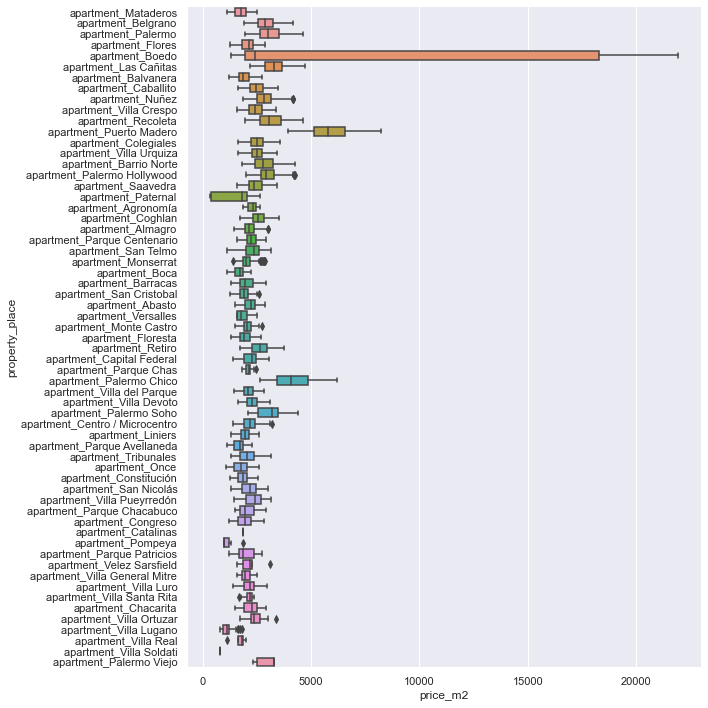

In [144]:
sns.catplot(y="property_place", x="price_m2",
                data=df_prop3[df_prop3['property_type']=='apartment'], kind="box",
                height=10, orient='h');

# Verificando o resultado da eliminação de outliers do tipo PH

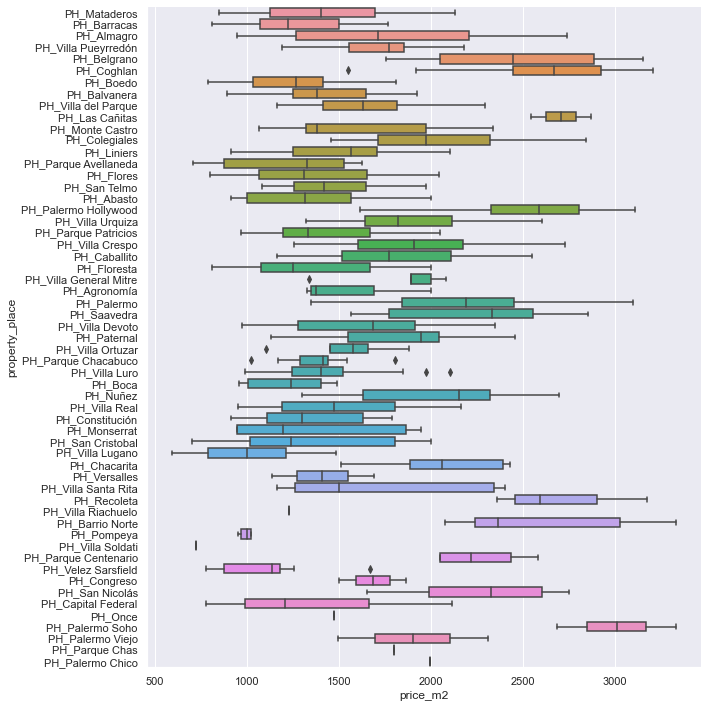

In [145]:
sns.catplot(y="property_place", x="price_m2",
                data=df_prop3[df_prop3['property_type']=='PH'], kind="box",
                height=10, orient='h');

# Verificando o resultado da eliminação de outliers do tipo house

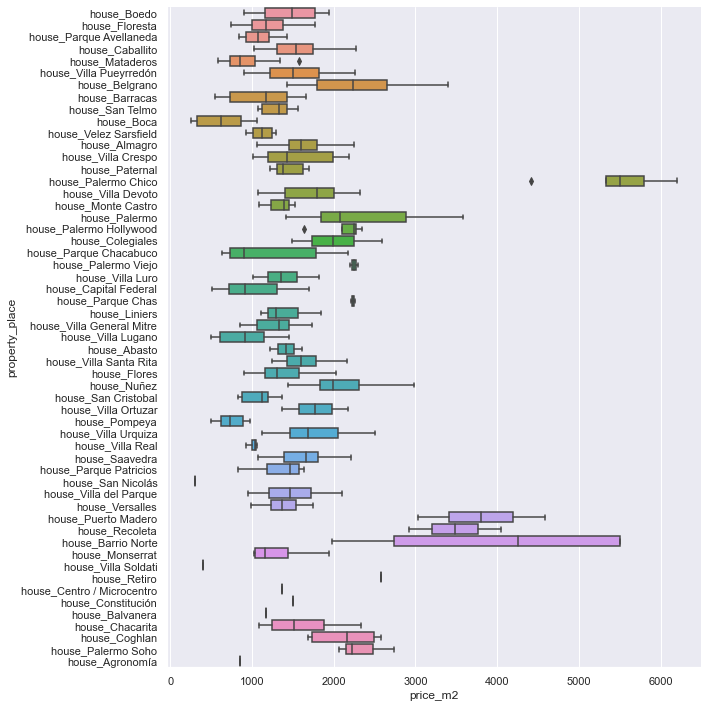

In [146]:
sns.catplot(y="property_place", x="price_m2",
                data=df_prop3[df_prop3['property_type']=='house'], kind="box",
                height=10, orient='h');

# Verificando o resultado da eliminação de outliers do tipo store

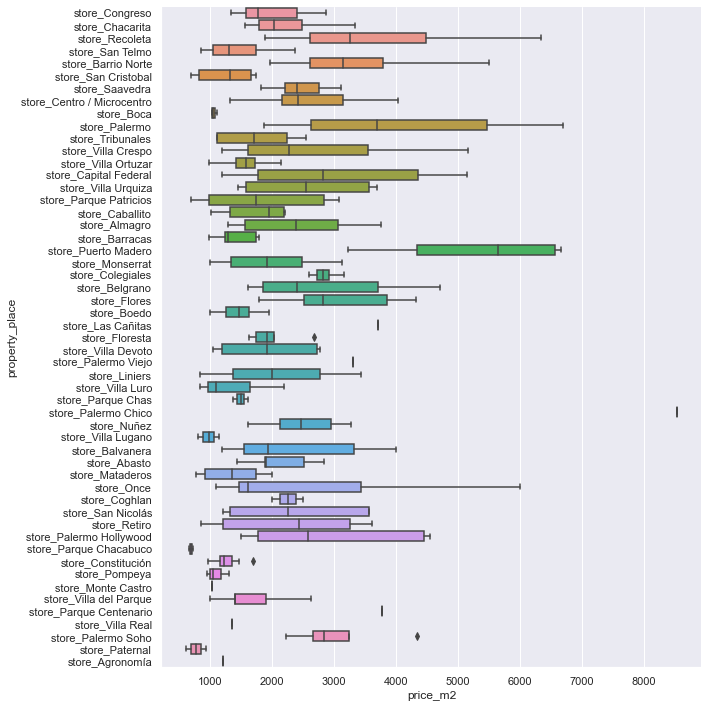

In [147]:
sns.catplot(y="property_place", x="price_m2",
                data=df_prop3[df_prop3['property_type']=='store'], kind="box",
                height=10, orient='h');

# Verificando como ficou o DataFrame

In [148]:
df_prop3.describe()

lat           lon         price      total_m2     price_usd  \
count  14896.000000  14896.000000  1.489600e+04  14896.000000  1.489600e+04   
mean     -34.600566    -58.434793  2.405596e+05    100.301187  2.391080e+05   
std        0.025944      0.039401  2.975169e+05    151.714104  2.956806e+05   
min      -34.694365    -58.544722  2.240000e+04     10.000000  9.281915e+03   
25%      -34.620221    -58.463837  1.050000e+05     44.000000  1.045000e+05   
50%      -34.601201    -58.436103  1.520000e+05     65.000000  1.520000e+05   
75%      -34.582510    -58.403479  2.600000e+05    110.000000  2.600000e+05   
max      -34.535096    -58.354956  8.000000e+06   7722.000000  8.000000e+06   

           price_m2  
count  14896.000000  
mean    2563.206469  
std     1436.218080  
min      257.142857  
25%     1952.938988  
50%     2375.000000  
75%     2875.160256  
max    21935.483871

# Identificando place_name com menor número de imóveis e iremos eliminar os registros em bairros com menos de 10 registros
 - Primeiro iremos criar uma coluna para armazenar quantos registros existem por bairro

In [149]:
df_prop3['count_place'] = df_prop3.groupby('place_name')['place_name'].transform('count')

 - Abaixo verificamos quantas linhas temos no DataFrame

In [150]:
print(df_prop3.shape)

(14896, 13)


 - Verificamos se foi alimentado o contador de bairros

In [151]:
df_prop3.loc[0:5,['place_name','count_place']].sort_values('count_place')

place_name  count_place
0  Mataderos          164
1  Mataderos          164
4  Mataderos          164
5    Palermo         1232
2   Belgrano         1269
3   Belgrano         1269

 - Verificando o número de registros por bairro

In [152]:
df_prop3.place_name.value_counts()

Caballito          1303
Belgrano           1269
Palermo            1232
Recoleta            851
Flores              786
                   ... 
Parque Chas          15
Palermo Viejo        10
Villa Soldati         4
Catalinas             1
Villa Riachuelo       1
Name: place_name, Length: 62, dtype: int64

In [153]:
# criação de uma mascara com quantidade menor que 10 e observando a porcentagem de registros
df_prop3_mask_menor10 = df_prop3.count_place < 10
# observando a porcentagem de valores com menos de 10 propriedades por bairro
df_prop3_menor10 = df_prop3.loc[df_prop3_mask_menor10,['count_place']]
df_prop3_menor10.shape[0] / df_prop3.shape[0] * 100

0.040279269602577876

In [154]:
# dropando as linhas com a mascara criada
df_prop3 = df_prop3.drop(df_prop3[df_prop3_mask_menor10].index)

In [155]:
# observando a quantidade de linhas após o drop 
df_prop3.shape

(14890, 13)

In [156]:
# observando a quantidade de valores após dropar os registros
df_prop3['place_name'].value_counts().sort_values().head(5)

Palermo Viejo      10
Parque Chas        15
Pompeya            21
Velez Sarsfield    21
Versalles          24
Name: place_name, dtype: int64

In [157]:
# observando os valores da coluna price_m2
df_prop3['price_m2'].sort_values().head(10)

1224    257.142857
9077    289.017341
3034    301.984469
9084    312.500000
70      340.452396
332     343.511450
58      343.774626
71      344.938749
65      345.711847
59      348.174416
Name: price_m2, dtype: float64

In [158]:
df_prop3.head(5)

property_type place_name country_name       state_name        lat  \
0            PH  Mataderos    Argentina  Capital Federal -34.661824   
1     apartment  Mataderos    Argentina  Capital Federal -34.652262   
2     apartment   Belgrano    Argentina  Capital Federal -34.559873   
3     apartment   Belgrano    Argentina  Capital Federal -34.559873   
4            PH  Mataderos    Argentina  Capital Federal -34.652356   

         lon     price currency  total_m2  price_usd     price_m2  \
0 -58.508839   62000.0      USD      55.0    62000.0  1127.272727   
1 -58.522982   72000.0      USD      55.0    72000.0  1309.090909   
2 -58.443362  138000.0      USD      45.0   138000.0  3066.666667   
3 -58.443362  195000.0      USD      65.0   195000.0  3000.000000   
4 -58.501624  239000.0      USD     140.0   239000.0  1707.142857   

        property_place  count_place  
0         PH_Mataderos          164  
1  apartment_Mataderos          164  
2   apartment_Belgrano         1269  
3   apartment_Belgrano         1269  
4         PH_Mataderos          164

# Verificamos se há algum imóvel com total_m2 muito alto ou baixo. Poderia influenciar no price_m2

In [159]:
df_prop3[['place_name','property_type','price_m2','total_m2']].sort_values('total_m2', ascending=False)

place_name property_type     price_m2  total_m2
10993             Boca         store  1036.001036    7722.0
13520        San Telmo         store   846.623351    5079.0
11085  Capital Federal         store  1354.166667    4800.0
10944       Villa Luro         store   833.333333    4800.0
11025        San Telmo         store  1052.631579    3800.0
...                ...           ...          ...       ...
12963          Almagro         store  3333.333333      12.0
10986     Barrio Norte         store  2083.333333      12.0
1318           Palermo         store  2583.333333      12.0
4103          Belgrano         store  3916.666667      12.0
7646            Flores         store  2500.000000      10.0

[14890 rows x 4 columns]

# Criando array com os quartis com a média do preço por metro quadrado
Percebemos a influência de alguns bairros com price_m2 mais alto no último quartil, Apartamentos em Boedo, por exemplo.

In [160]:
# calculando os quartis dos preços por m2 na serie  
q_price_m2	 = pd.qcut(df_prop3.price_m2	, 4)
print(type(q_price_m2))
q_price_m2

<class 'pandas.core.series.Series'>


0         (257.142, 1953.125]
1         (257.142, 1953.125]
2        (2875.99, 21935.484]
3        (2875.99, 21935.484]
4         (257.142, 1953.125]
                 ...         
17218     (257.142, 1953.125]
17219    (2875.99, 21935.484]
17220       (2375.0, 2875.99]
17221       (2375.0, 2875.99]
17222       (2375.0, 2875.99]
Name: price_m2, Length: 14890, dtype: category
Categories (4, interval[float64, right]): [(257.142, 1953.125] < (1953.125, 2375.0] < (2375.0, 2875.99] < (2875.99, 21935.484]]

# Criando variável da média do price_m2 por property_type e place_name

In [161]:
df_prop3['avg_price_m2'] = df_prop3.groupby('property_place')['price_m2'].transform('mean')

In [162]:
df_prop3.head(10)

property_type   place_name country_name       state_name        lat  \
0            PH    Mataderos    Argentina  Capital Federal -34.661824   
1     apartment    Mataderos    Argentina  Capital Federal -34.652262   
2     apartment     Belgrano    Argentina  Capital Federal -34.559873   
3     apartment     Belgrano    Argentina  Capital Federal -34.559873   
4            PH    Mataderos    Argentina  Capital Federal -34.652356   
5     apartment      Palermo    Argentina  Capital Federal -34.580504   
6     apartment      Palermo    Argentina  Capital Federal -34.590926   
7     apartment       Flores    Argentina  Capital Federal -34.635118   
8     apartment        Boedo    Argentina  Capital Federal -34.621769   
9     apartment  Las Cañitas    Argentina  Capital Federal -34.571150   

         lon     price currency  total_m2  price_usd     price_m2  \
0 -58.508839   62000.0      USD      55.0    62000.0  1127.272727   
1 -58.522982   72000.0      USD      55.0    72000.0  1309.090909   
2 -58.443362  138000.0      USD      45.0   138000.0  3066.666667   
3 -58.443362  195000.0      USD      65.0   195000.0  3000.000000   
4 -58.501624  239000.0      USD     140.0   239000.0  1707.142857   
5 -58.405874  350000.0      USD     104.0   350000.0  3365.384615   
6 -58.411665  270500.0      USD     118.0   270500.0  2292.372881   
7 -58.473964   75000.0      USD      43.0    75000.0  1744.186047   
8 -58.422108  145000.0      USD      80.0   145000.0  1812.500000   
9 -58.423297  480000.0      USD     220.0   480000.0  2181.818182   

          property_place  count_place  avg_price_m2  
0           PH_Mataderos          164   1439.097374  
1    apartment_Mataderos          164   1738.252424  
2     apartment_Belgrano         1269   2921.082578  
3     apartment_Belgrano         1269   2921.082578  
4           PH_Mataderos          164   1439.097374  
5      apartment_Palermo         1232   3089.924702  
6      apartment_Palermo         1232   3089.924702  
7       apartment_Flores          786   2074.069477  
8        apartment_Boedo          228   8995.770491  
9  apartment_Las Cañitas          112   3303.923042

# Análise espacial da localização das propriedades com o Geopandas
Verificamos o DataFrame e percebemos que existem somente registros de Buenos Aires Capital. Diante disso importamos um arquivo com os perímetros dos bairros de Buenos Aires Capita e posteriormente iremos analisar se há algum registro fora e eliminá-los.

In [163]:
df_bairros = pd.read_csv("../Data/Neighborhoods.csv", encoding = 'latin1')
df_bairros.head()

WKT      NEIGHBORHOOD  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         CHACARITA   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          PATERNAL   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      VILLA CRESPO   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  VILLA DEL PARQUE   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           ALMAGRO   

   COMMUNE    PERIMETER          AREA  
0     15.0  7725.695228  3.118101e+06  
1     15.0  7087.513295  2.229829e+06  
2     15.0  8132.699348  3.613584e+06  
3     11.0  7705.389797  3.399596e+06  
4      5.0  8537.901368  4.050752e+06

 - Convertendo os bairros de DataFrame para GeoDataFrame

In [164]:
df_bairros["WKT"] = df_bairros["WKT"].apply(shapely.wkt.loads)
geo_bairros = gpd.GeoDataFrame(df_bairros, geometry = 'WKT' )
type(geo_bairros)

geopandas.geodataframe.GeoDataFrame

 - Observando os bairros geograficamente

C:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Anaconda\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

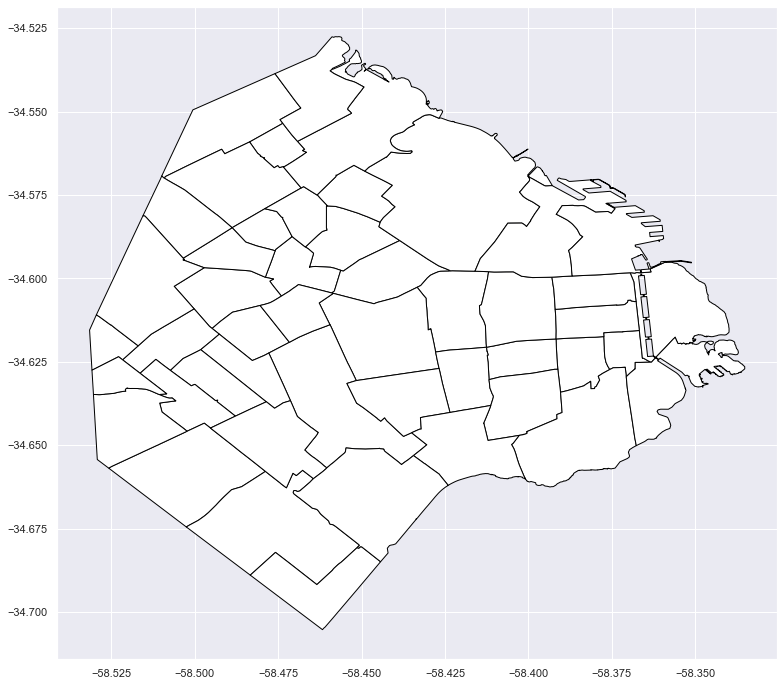

In [165]:
geo_bairros.plot(color = 'white', edgecolor='black', figsize=(20,12))

 - Visualização das colunas do dataframe de propriedades

In [166]:
df_prop3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14890 entries, 0 to 17222
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   property_type   14890 non-null  object 
 1   place_name      14890 non-null  object 
 2   country_name    14890 non-null  object 
 3   state_name      14890 non-null  object 
 4   lat             14890 non-null  float64
 5   lon             14890 non-null  float64
 6   price           14890 non-null  float64
 7   currency        14890 non-null  object 
 8   total_m2        14890 non-null  float64
 9   price_usd       14890 non-null  float64
 10  price_m2        14890 non-null  float64
 11  property_place  14890 non-null  object 
 12  count_place     14890 non-null  int64  
 13  avg_price_m2    14890 non-null  float64
dtypes: float64(7), int64(1), object(6)
memory usage: 1.7+ MB


 - Conversão das colunas latitude (lat) e longitude (lon) do dataframe propriedade em pontos geométricos

In [167]:
geometria = gpd.points_from_xy(df_prop3['lon'],df_prop3['lat'])
geometria[0:2]

 - Inserindo os pontos geometricos numa nova coluna chamada geometry do dataframe de propriedade df_prop

In [168]:
df_prop3 = gpd.GeoDataFrame(df_prop3,
                            geometry = geometria
                           )

C:\Anaconda\lib\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


 - Observando as colunas com os dados geometricos no dataframe de propriedades df_prop3

In [169]:
df_prop3.loc[ : , ['geometry', 'lat', 'lon', 'property_type', 'place_name']]

geometry        lat        lon property_type  \
0      POINT (-58.50884 -34.66182) -34.661824 -58.508839            PH   
1      POINT (-58.52298 -34.65226) -34.652262 -58.522982     apartment   
2      POINT (-58.44336 -34.55987) -34.559873 -58.443362     apartment   
3      POINT (-58.44336 -34.55987) -34.559873 -58.443362     apartment   
4      POINT (-58.50162 -34.65236) -34.652356 -58.501624            PH   
...                            ...        ...        ...           ...   
17218  POINT (-58.40252 -34.59921) -34.599214 -58.402519     apartment   
17219  POINT (-58.39737 -34.58743) -34.587425 -58.397372     apartment   
17220  POINT (-58.44268 -34.56369) -34.563685 -58.442683     apartment   
17221  POINT (-58.44268 -34.56369) -34.563685 -58.442683     apartment   
17222  POINT (-58.47560 -34.57064) -34.570639 -58.475596     apartment   

          place_name  
0          Mataderos  
1          Mataderos  
2           Belgrano  
3           Belgrano  
4          Mataderos  
...              ...  
17218   Barrio Norte  
17219       Recoleta  
17220       Belgrano  
17221       Belgrano  
17222  Villa Urquiza  

[14890 rows x 5 columns]

 - Observando os dados de latitude e longitude para verificar se existe algum ponto muito distante

In [170]:
df_prop3.sort_values(by='lat')

property_type    place_name country_name       state_name        lat  \
6026             PH  Villa Lugano    Argentina  Capital Federal -34.694365   
6027             PH  Villa Lugano    Argentina  Capital Federal -34.694365   
8578          house  Villa Lugano    Argentina  Capital Federal -34.693845   
3570      apartment  Villa Lugano    Argentina  Capital Federal -34.692181   
16164            PH  Villa Lugano    Argentina  Capital Federal -34.691363   
...             ...           ...          ...              ...        ...   
6736      apartment         Nuñez    Argentina  Capital Federal -34.536811   
8506      apartment         Nuñez    Argentina  Capital Federal -34.536801   
10415     apartment         Nuñez    Argentina  Capital Federal -34.536202   
9082      apartment         Nuñez    Argentina  Capital Federal -34.536155   
12369            PH     Mataderos    Argentina  Capital Federal -34.535096   

             lon     price currency  total_m2  price_usd     price_m2  \
6026  -58.467574  235000.0      USD     301.0   235000.0   780.730897   
6027  -58.467574  235000.0      USD     301.0   235000.0   780.730897   
8578  -58.470129  200000.0      USD     150.0   200000.0  1333.333333   
3570  -58.471688   95000.0      USD      58.0    95000.0  1637.931034   
16164 -58.475261   90000.0      USD      68.0    90000.0  1323.529412   
...          ...       ...      ...       ...        ...          ...   
6736  -58.466233  260000.0      USD      71.0   260000.0  3661.971831   
8506  -58.466784  210000.0      USD      67.0   210000.0  3134.328358   
10415 -58.467530  119000.0      USD      56.0   119000.0  2125.000000   
9082  -58.468274  230000.0      USD      92.0   230000.0  2500.000000   
12369 -58.465655  164000.0      USD     177.0   164000.0   926.553672   

               property_place  count_place  avg_price_m2  \
6026          PH_Villa Lugano           88   1011.081997   
6027          PH_Villa Lugano           88   1011.081997   
8578       house_Villa Lugano           88    909.203910   
3570   apartment_Villa Lugano           88   1142.543379   
16164         PH_Villa Lugano           88   1011.081997   
...                       ...          ...           ...   
6736          apartment_Nuñez          311   2852.446549   
8506          apartment_Nuñez          311   2852.446549   
10415         apartment_Nuñez          311   2852.446549   
9082          apartment_Nuñez          311   2852.446549   
12369            PH_Mataderos          164   1439.097374   

                          geometry  
6026   POINT (-58.46757 -34.69436)  
6027   POINT (-58.46757 -34.69436)  
8578   POINT (-58.47013 -34.69384)  
3570   POINT (-58.47169 -34.69218)  
16164  POINT (-58.47526 -34.69136)  
...                            ...  
6736   POINT (-58.46623 -34.53681)  
8506   POINT (-58.46678 -34.53680)  
10415  POINT (-58.46753 -34.53620)  
9082   POINT (-58.46827 -34.53616)  
12369  POINT (-58.46566 -34.53510)  

[14890 rows x 15 columns]

# Iremos analisar alguns gráficos com o preço médio por m2 por tipo de propriedade e bairro

C:\Users\ANDREI~1\AppData\Local\Temp/ipykernel_21152/329722371.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_bairro_apart['place_name'] = avg_bairro_apart['place_name'].str.upper()
C:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Anaconda\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Anaconda\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array

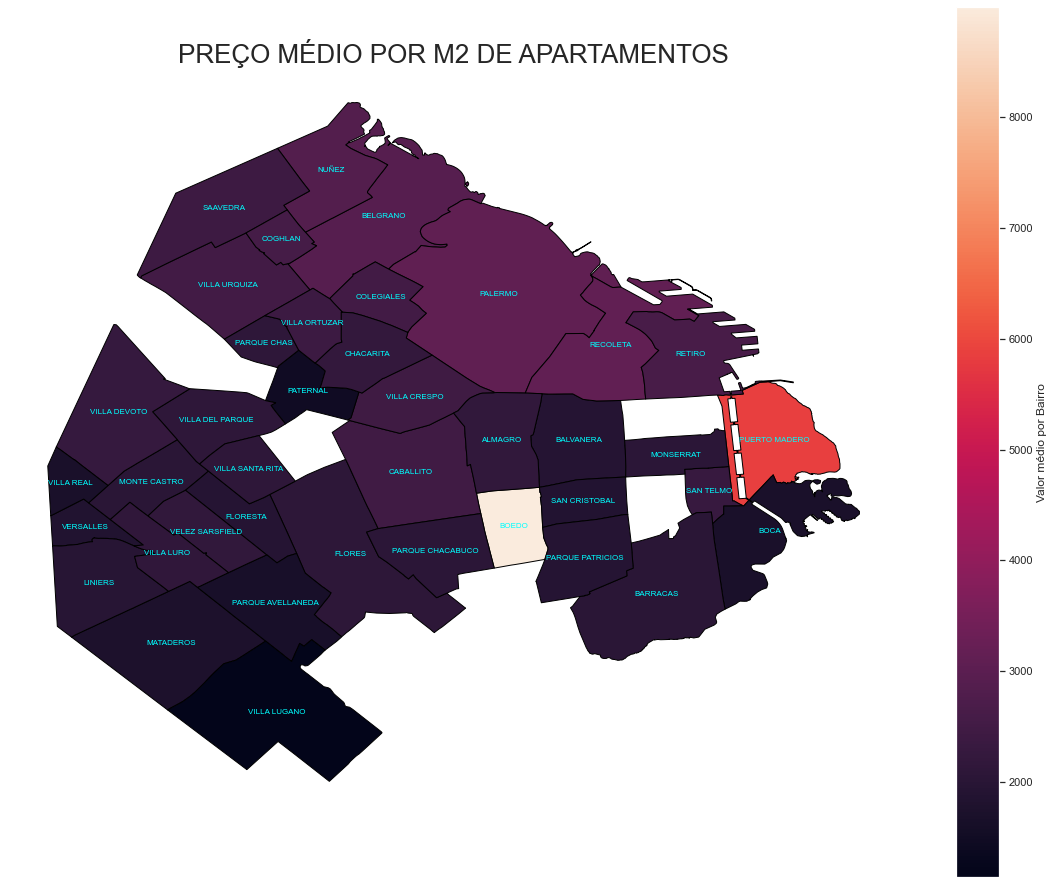

In [171]:
df_apart = df_prop3.loc[ : , ['property_type', 'place_name', 'avg_price_m2']]

avg_bairro_apart = df_apart.loc[df_apart['property_type'] == 'apartment']
avg_bairro_apart['place_name'] = avg_bairro_apart['place_name'].str.upper()

geodata_apart = pd.merge(left=avg_bairro_apart, right=df_bairros, left_on='place_name', right_on='NEIGHBORHOOD', how='inner')
geodata_apart = geodata_apart.rename(columns={"WKT": "geometry"})
geodata_apart = geodata_apart.drop(columns=['NEIGHBORHOOD','COMMUNE','PERIMETER','AREA'])
geodata_apart = geodata_apart.drop_duplicates(subset=['place_name'])

geodf_apart = gpd.GeoDataFrame(geodata_apart)

ax = geodf_apart.loc[geodf_apart['property_type'] == 'apartment'].plot(
    figsize=(20,16),
    edgecolor='black',column='avg_price_m2',
    legend=True,
    legend_kwds={'label': "Valor médio por Bairro",'orientation':"vertical" })

for i in geodf_apart.index:
    plt.text(geodf_apart.geometry.centroid[i].coords[0][0], geodf_apart.geometry.centroid[i].coords[0][1], geodf_apart.place_name[i],
             fontsize=8, horizontalalignment='center', verticalalignment='center', color = 'cyan')
    
ax.set_axis_off();
ax.set_title("PREÇO MÉDIO POR M2 DE APARTAMENTOS",fontsize=26);

C:\Users\ANDREI~1\AppData\Local\Temp/ipykernel_21152/1556863245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_bairro_PH['place_name'] = avg_bairro_PH['place_name'].str.upper()
C:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Anaconda\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
C:\Anaconda\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array inter

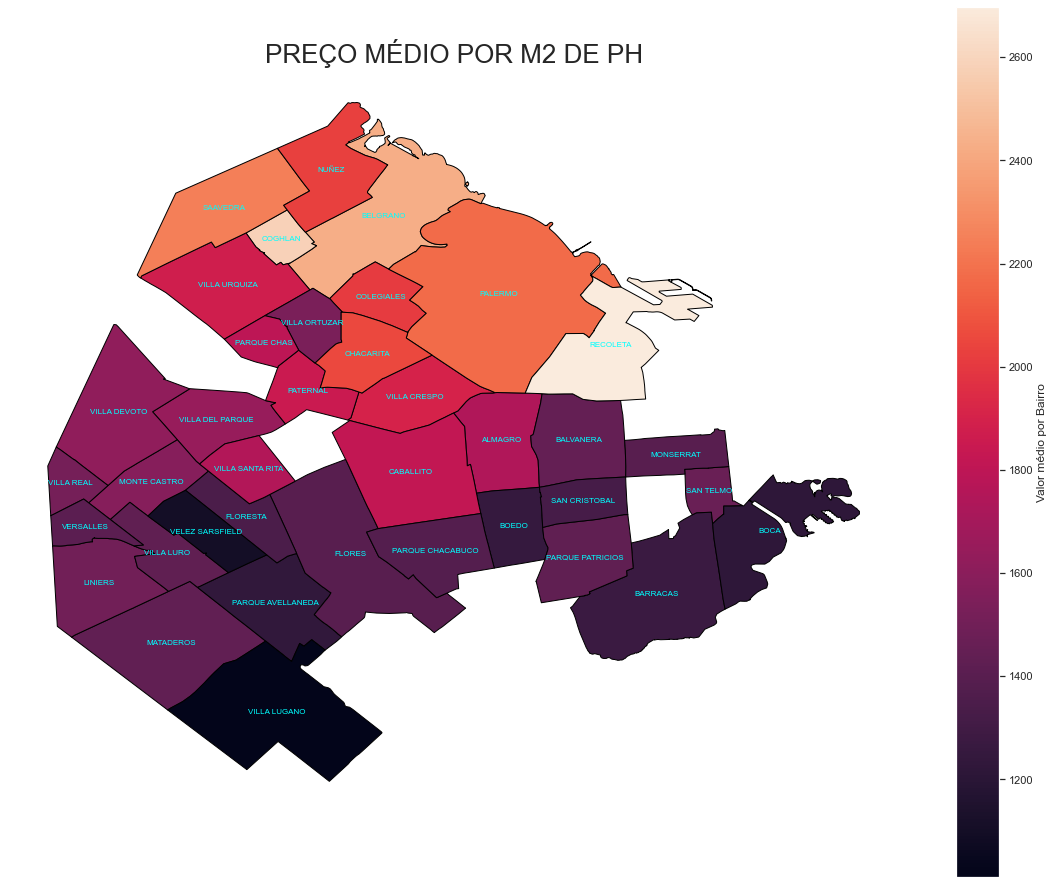

In [172]:
df_PH = df_prop3.loc[ : , ['property_type', 'place_name', 'avg_price_m2']]

avg_bairro_PH = df_PH.loc[df_PH['property_type'] == 'PH']
avg_bairro_PH['place_name'] = avg_bairro_PH['place_name'].str.upper()

geodata_PH = pd.merge(left=avg_bairro_PH, right=df_bairros, left_on='place_name', right_on='NEIGHBORHOOD', how='inner')
geodata_PH = geodata_PH.rename(columns={"WKT": "geometry"})
geodata_PH = geodata_PH.drop(columns=['NEIGHBORHOOD','COMMUNE','PERIMETER','AREA'])
geodata_PH = geodata_PH.drop_duplicates(subset=['place_name'])

geodf_PH = gpd.GeoDataFrame(geodata_PH)

ax = geodf_PH.loc[geodf_PH['property_type'] == 'PH'].plot(
    figsize=(20,16),
    edgecolor='black',column='avg_price_m2',
    legend=True,
    legend_kwds={'label': "Valor médio por Bairro",'orientation':"vertical" })

for i in geodf_PH.index:
    plt.text(geodf_PH.geometry.centroid[i].coords[0][0], geodf_PH.geometry.centroid[i].coords[0][1], geodf_PH.place_name[i],
             fontsize=8, horizontalalignment='center', verticalalignment='center', color = 'cyan')
    
ax.set_axis_off();
ax.set_title("PREÇO MÉDIO POR M2 DE PH",fontsize=26);

C:\Users\ANDREI~1\AppData\Local\Temp/ipykernel_21152/613839946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_bairro_store['place_name'] = avg_bairro_store['place_name'].str.upper()
C:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Anaconda\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Anaconda\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array

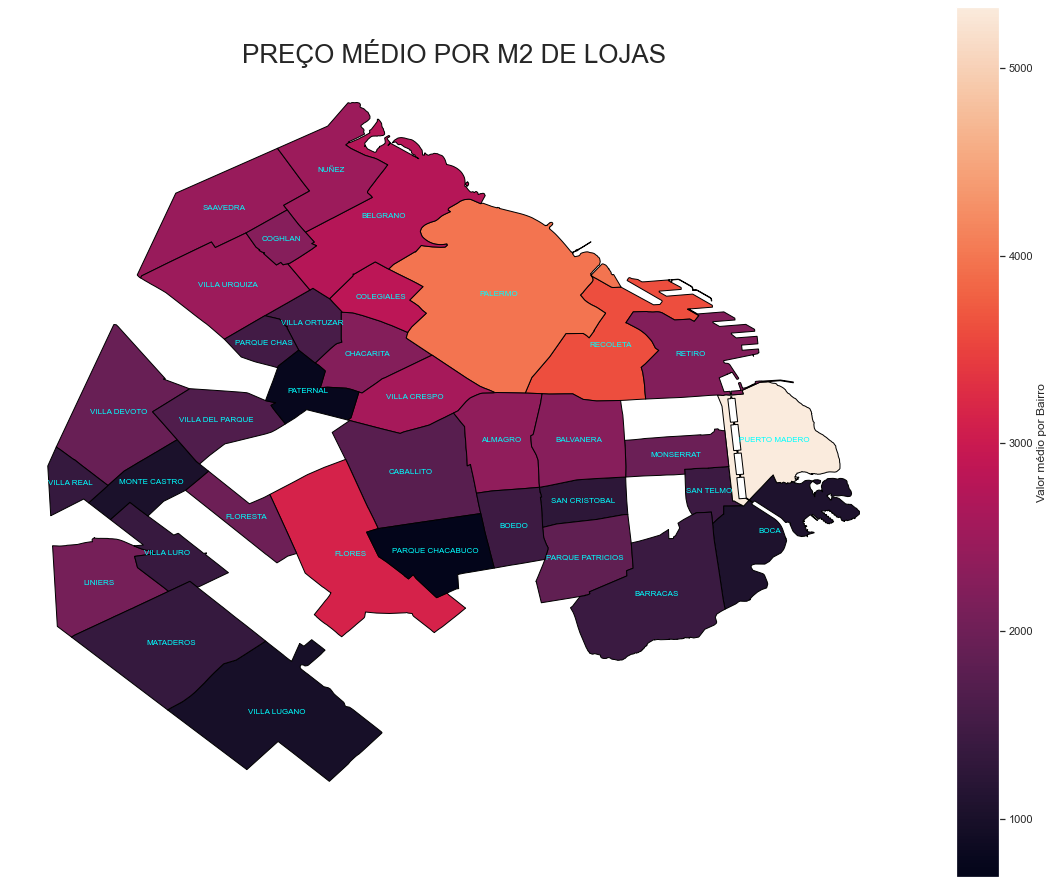

In [173]:
df_store = df_prop3.loc[ : , ['property_type', 'place_name', 'avg_price_m2']]

avg_bairro_store = df_store.loc[df_store['property_type'] == 'store']
avg_bairro_store['place_name'] = avg_bairro_store['place_name'].str.upper()

geodata_store = pd.merge(left=avg_bairro_store, right=df_bairros, left_on='place_name', right_on='NEIGHBORHOOD', how='inner')
geodata_store = geodata_store.rename(columns={"WKT": "geometry"})
geodata_store = geodata_store.drop(columns=['NEIGHBORHOOD','COMMUNE','PERIMETER','AREA'])
geodata_store = geodata_store.drop_duplicates(subset=['place_name'])

geodf_store = gpd.GeoDataFrame(geodata_store)

ax = geodf_store.loc[geodf_store['property_type'] == 'store'].plot(
    figsize=(20,16),
    edgecolor='black',column='avg_price_m2',
    legend=True,
    legend_kwds={'label': "Valor médio por Bairro",'orientation':"vertical" })

for i in geodf_store.index:
    plt.text(geodf_store.geometry.centroid[i].coords[0][0], geodf_store.geometry.centroid[i].coords[0][1], geodf_store.place_name[i],
             fontsize=8, horizontalalignment='center', verticalalignment='center', color = 'cyan')
    
ax.set_axis_off();
ax.set_title("PREÇO MÉDIO POR M2 DE LOJAS",fontsize=26);

C:\Users\ANDREI~1\AppData\Local\Temp/ipykernel_21152/3792150831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_bairro_house['place_name'] = avg_bairro_house['place_name'].str.upper()
C:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Anaconda\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Anaconda\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The arra

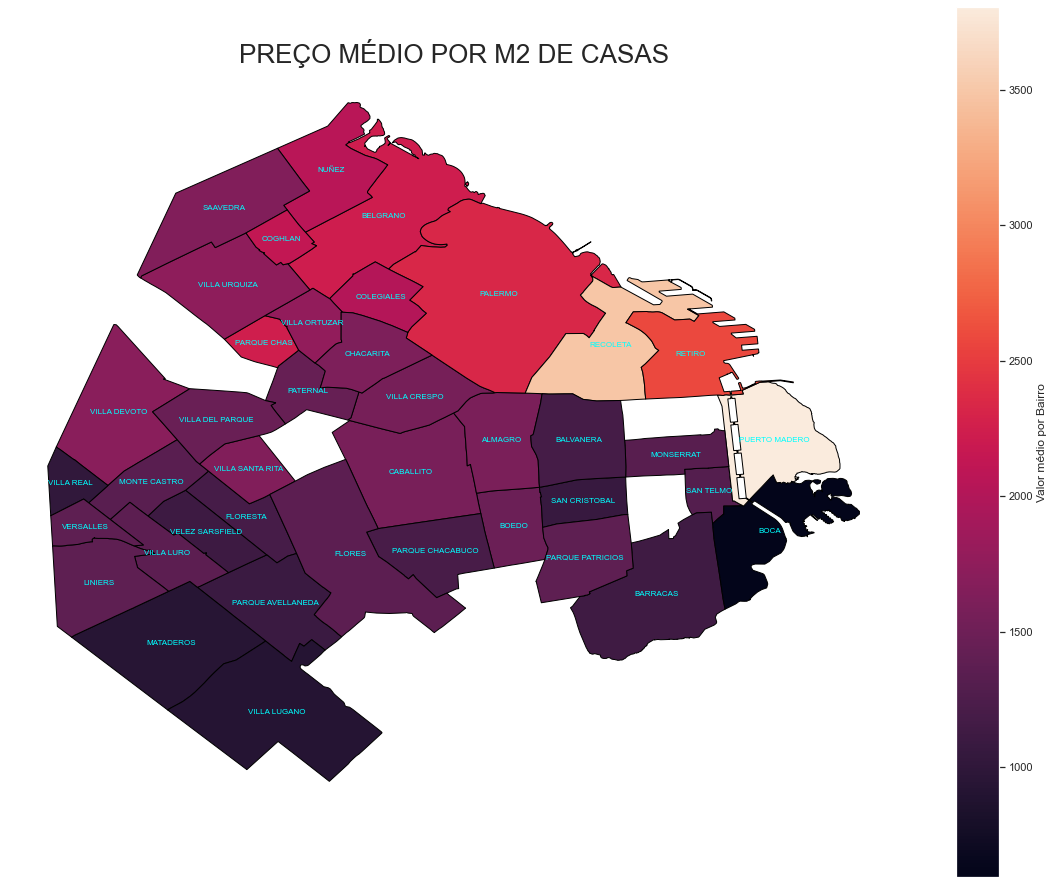

In [174]:
df_house = df_prop3.loc[ : , ['property_type', 'place_name', 'avg_price_m2']]

avg_bairro_house = df_house.loc[df_house['property_type'] == 'house']
avg_bairro_house['place_name'] = avg_bairro_house['place_name'].str.upper()

geodata_house = pd.merge(left=avg_bairro_house, right=df_bairros, left_on='place_name', right_on='NEIGHBORHOOD', how='inner')
geodata_house = geodata_house.rename(columns={"WKT": "geometry"})
geodata_house = geodata_house.drop(columns=['NEIGHBORHOOD','COMMUNE','PERIMETER','AREA'])
geodata_house = geodata_house.drop_duplicates(subset=['place_name'])

geodf_house = gpd.GeoDataFrame(geodata_house)

ax = geodf_house.loc[geodf_house['property_type'] == 'house'].plot(
    figsize=(20,16),
    edgecolor='black',column='avg_price_m2',
    legend=True,
    legend_kwds={'label': "Valor médio por Bairro",'orientation':"vertical" })

for i in geodf_house.index:
    plt.text(geodf_house.geometry.centroid[i].coords[0][0], geodf_house.geometry.centroid[i].coords[0][1], geodf_house.place_name[i],
             fontsize=8, horizontalalignment='center', verticalalignment='center', color = 'cyan')
    
ax.set_axis_off();
ax.set_title("PREÇO MÉDIO POR M2 DE CASAS",fontsize=26);

# Visualização geográfica das propriedades por tipos de propriedade
 - Criaçao de um dataframe para propriedade do tipo apartamento

In [175]:
df_apartment = df_prop3.loc[df_prop3['property_type'] == 'apartment', :]
display(df_apartment.head(3))

property_type place_name country_name       state_name        lat  \
1     apartment  Mataderos    Argentina  Capital Federal -34.652262   
2     apartment   Belgrano    Argentina  Capital Federal -34.559873   
3     apartment   Belgrano    Argentina  Capital Federal -34.559873   

         lon     price currency  total_m2  price_usd     price_m2  \
1 -58.522982   72000.0      USD      55.0    72000.0  1309.090909   
2 -58.443362  138000.0      USD      45.0   138000.0  3066.666667   
3 -58.443362  195000.0      USD      65.0   195000.0  3000.000000   

        property_place  count_place  avg_price_m2                     geometry  
1  apartment_Mataderos          164   1738.252424  POINT (-58.52298 -34.65226)  
2   apartment_Belgrano         1269   2921.082578  POINT (-58.44336 -34.55987)  
3   apartment_Belgrano         1269   2921.082578  POINT (-58.44336 -34.55987)

 - Criação de um série para receber a coluna geometry de propriedades tipo apartamento

In [176]:
geo_apartment = df_apartment['geometry']

 - Criaçao de um dataframe para propriedade do tipo HOUSE

In [177]:
df_house = df_prop3.loc[df_prop3['property_type'] == 'house', :]
display(df_house.head(3))

property_type         place_name country_name       state_name        lat  \
12          house              Boedo    Argentina  Capital Federal -34.636321   
93          house           Floresta    Argentina  Capital Federal -34.633833   
103         house  Parque Avellaneda    Argentina  Capital Federal -34.646055   

           lon     price currency  total_m2  price_usd     price_m2  \
12  -58.410702  550000.0      USD     504.0   550000.0  1091.269841   
93  -58.492689  280000.0      USD     200.0   280000.0  1400.000000   
103 -58.491122  160000.0      USD     191.0   160000.0   837.696335   

              property_place  count_place  avg_price_m2  \
12               house_Boedo          228   1478.344754   
93            house_Floresta          251   1196.542541   
103  house_Parque Avellaneda           27   1088.477836   

                        geometry  
12   POINT (-58.41070 -34.63632)  
93   POINT (-58.49269 -34.63383)  
103  POINT (-58.49112 -34.64605)

 - Criação de um série para receber a coluna geometry de propriedades tipo HOUSE

In [178]:
geo_house = df_house['geometry']

 - Criaçao de um dataframe para propriedade do tipo PH

In [179]:
df_PH = df_prop3.loc[df_prop3['property_type'] == 'PH', :]
display(df_PH.head(3))

property_type place_name country_name       state_name        lat  \
0             PH  Mataderos    Argentina  Capital Federal -34.661824   
4             PH  Mataderos    Argentina  Capital Federal -34.652356   
22            PH   Barracas    Argentina  Capital Federal -34.650450   

          lon     price currency  total_m2  price_usd     price_m2  \
0  -58.508839   62000.0      USD      55.0    62000.0  1127.272727   
4  -58.501624  239000.0      USD     140.0   239000.0  1707.142857   
22 -58.382404  160000.0      USD     156.0   160000.0  1025.641026   

   property_place  count_place  avg_price_m2                     geometry  
0    PH_Mataderos          164   1439.097374  POINT (-58.50884 -34.66182)  
4    PH_Mataderos          164   1439.097374  POINT (-58.50162 -34.65236)  
22    PH_Barracas          274   1270.787958  POINT (-58.38240 -34.65045)

 - Criação de um série para receber a coluna geometry de propriedades tipo PH

In [180]:
geo_PH = df_PH['geometry']

 - Criaçao de um dataframe para propriedade do tipo store

In [181]:
df_store = df_prop3.loc[df_prop3['property_type'] == 'store', :]
display(df_store.head(3))

property_type place_name country_name       state_name        lat  \
25         store   Congreso    Argentina  Capital Federal -34.606297   
30         store  Chacarita    Argentina  Capital Federal -34.590181   
76         store   Recoleta    Argentina  Capital Federal -34.595967   

          lon     price currency  total_m2  price_usd     price_m2  \
25 -58.392189  295000.0      USD     103.0   295000.0  2864.077670   
30 -58.449152  175000.0      USD      80.0   175000.0  2187.500000   
76 -58.409774  139000.0      USD      33.0   139000.0  4212.121212   

     property_place  count_place  avg_price_m2                     geometry  
25   store_Congreso          152   1988.723695  POINT (-58.39219 -34.60630)  
30  store_Chacarita          107   2233.382937  POINT (-58.44915 -34.59018)  
76   store_Recoleta          851   3617.124244  POINT (-58.40977 -34.59597)

 - Criação de um série para receber a coluna geometry de propriedades tipo PH

In [182]:
geo_store = df_store['geometry']

In [183]:
plt.rcParams["figure.figsize"] = (20, 14)

C:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Anaconda\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


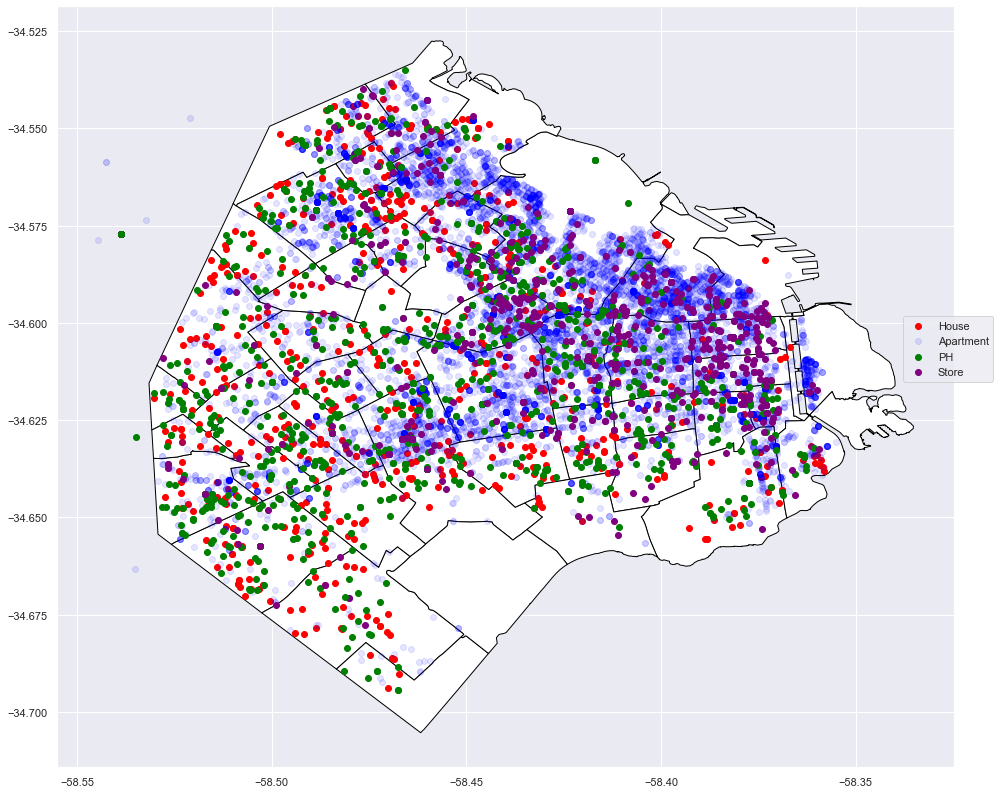

In [184]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
geo_bairros.plot(ax = ax,
                 color = 'white',
                 edgecolor = 'black',
                )
geo_house.plot(ax = ax,
               color = 'red'
              )
geo_apartment.plot(ax = ax,
                   color = 'blue',
                   alpha = 0.1
                  )
geo_PH.plot(ax = ax,
            color = 'green'
           )
geo_store.plot(ax = ax,
               color = 'purple'
              )
plt.legend(["House","Apartment","PH","Store"],
           bbox_to_anchor = (1.05, 0.6)
          )
                           
plt.show();

# Verificamos no gráfico acima que existem registros fora de Buenos Aires Capital. Em seguida iremos eliminar esses registros.

 - Quantidade de linhas e colunas

In [185]:
df_prop3.shape

(14890, 15)

 - Fazendo um join entre o dataframe das propriedades e bairro, o df_prop3 será atualizado apenas com as propriedades cuja localização está dentro de algum poligono de bairro

In [186]:
df_prop3 = gpd.sjoin(df_prop3, geo_bairros, how='inner', op='within')

 - Quantidade de linhas e colunas após o join

In [187]:
df_prop3.shape

(14860, 20)

# Alimentando as máscaras novamente para plotar o gráfico e checar se ficou ainda algum registro fora de Buenos Aires Capital

In [188]:
df_apartment = df_prop3.loc[df_prop3['property_type'] == 'apartment', :]
geo_apartment = df_apartment['geometry']
df_house = df_prop3.loc[df_prop3['property_type'] == 'house', :]
geo_house = df_house['geometry']
df_PH = df_prop3.loc[df_prop3['property_type'] == 'PH', :]
geo_PH = df_PH['geometry']
df_store = df_prop3.loc[df_prop3['property_type'] == 'store', :]
geo_PH = df_PH['geometry']
geo_store = df_store['geometry']

In [189]:
plt.rcParams["figure.figsize"] = (20, 14)

C:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Anaconda\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


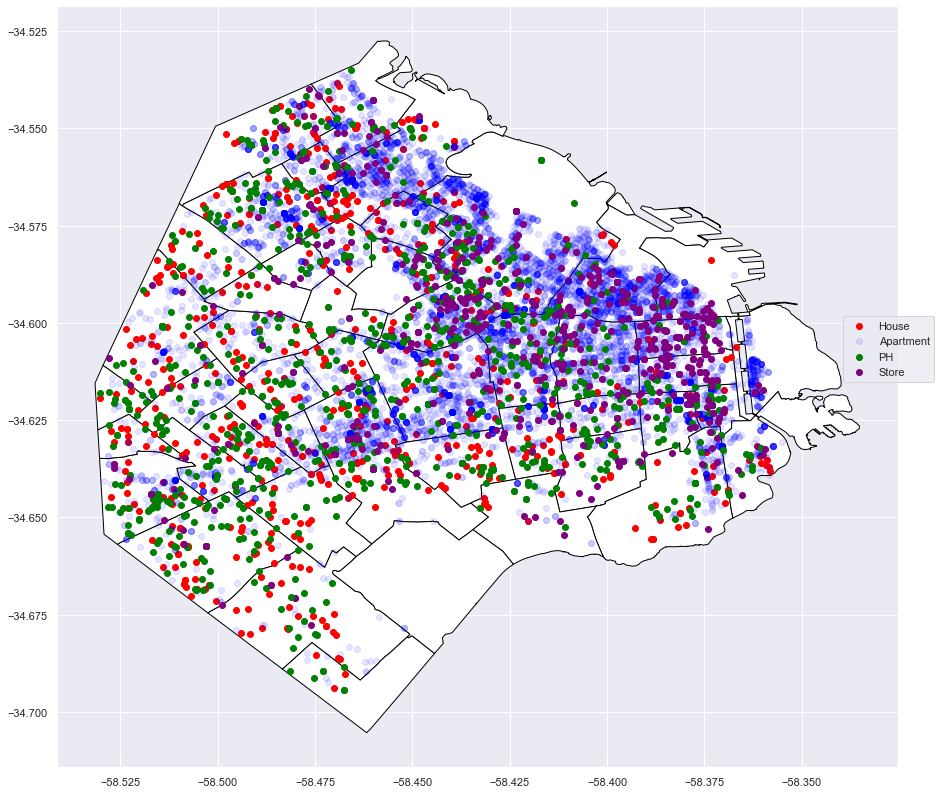

In [190]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
geo_bairros.plot(ax = ax,
                 color = 'white',
                 edgecolor = 'black',
                )
geo_house.plot(ax = ax,
               color = 'red'
              )
geo_apartment.plot(ax = ax,
                   color = 'blue',
                   alpha = 0.1
                  )
geo_PH.plot(ax = ax,
            color = 'green'
           )
geo_store.plot(ax = ax,
               color = 'purple'
              )
plt.legend(["House","Apartment","PH","Store"],
           bbox_to_anchor = (1.05, 0.6)
          )
                           
plt.show();

# Análise de Correlação

- Gráfico de dispersão do preço das propriedades tipo apartamento e o tamanho em m2

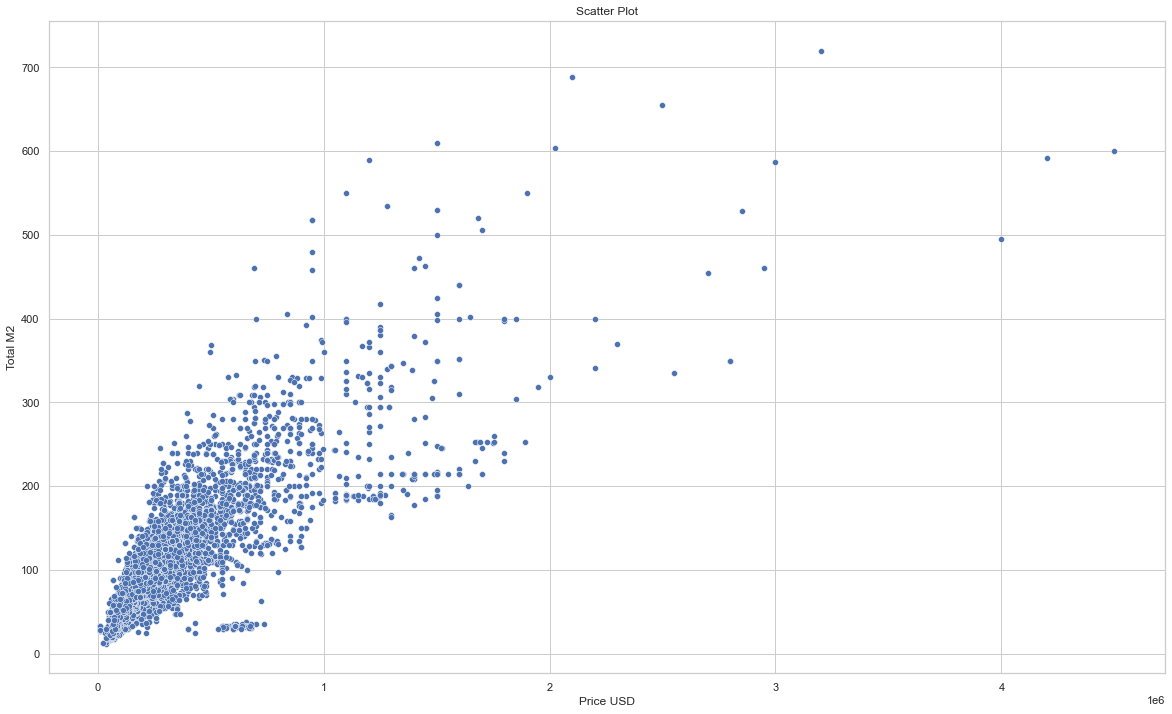

In [191]:
sns.set_style('whitegrid')
plt.figure(figsize = (20, 12))
sns.scatterplot(data = df_prop3[df_prop3['property_type']=='apartment'], x = "price_usd", y = "total_m2")
plt.xlabel("Price USD"); plt.ylabel("Total M2");plt.title("Scatter Plot")
plt.show()

# Abaixo verificamos a influência dos bairros nos preços por m2 em cada tipo de propriedade

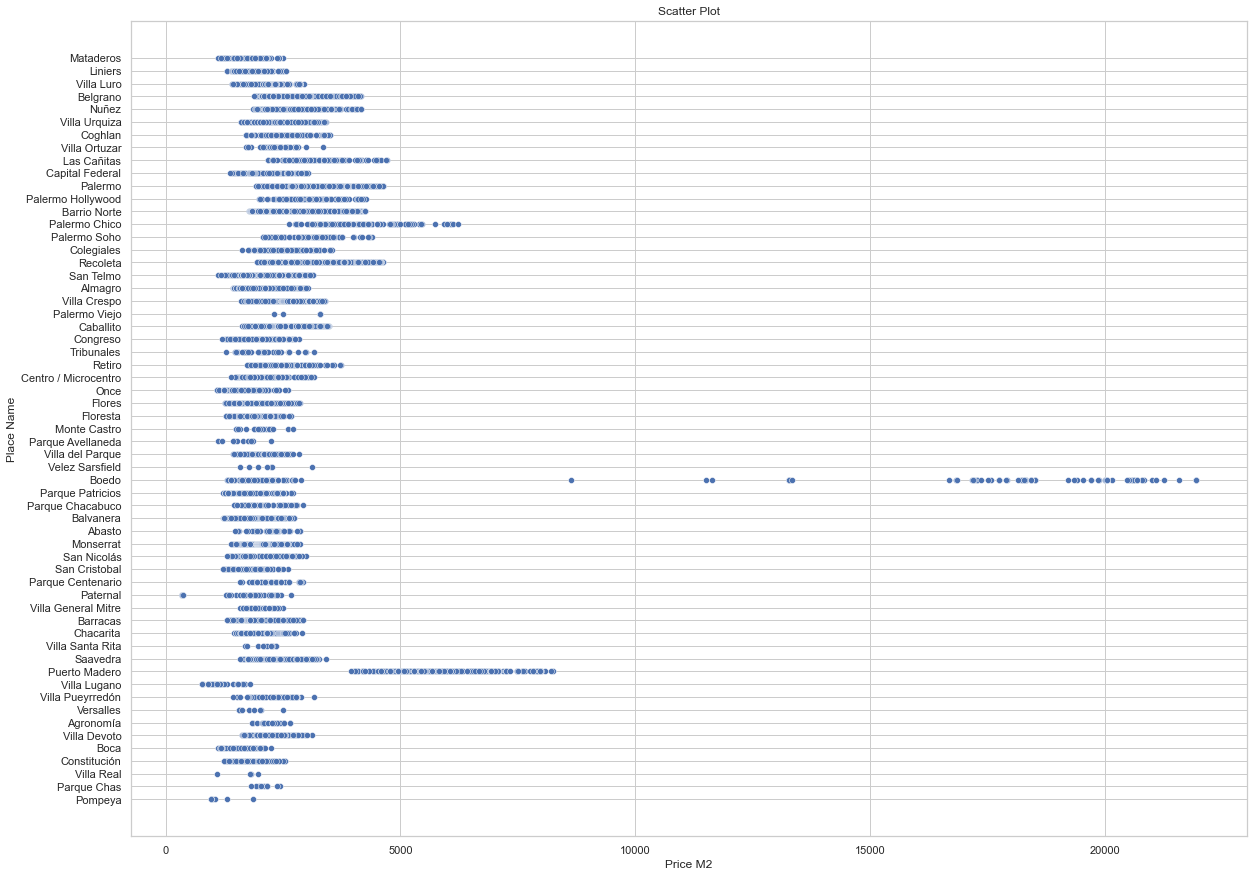

In [192]:
sns.set_style('whitegrid')
plt.figure(figsize = (20, 15))
sns.scatterplot(data = df_prop3[df_prop3['property_type']=='apartment'], x = "price_m2", y = "place_name")
plt.xlabel("Price M2"); plt.ylabel("Place Name");plt.title("Scatter Plot")
plt.show()

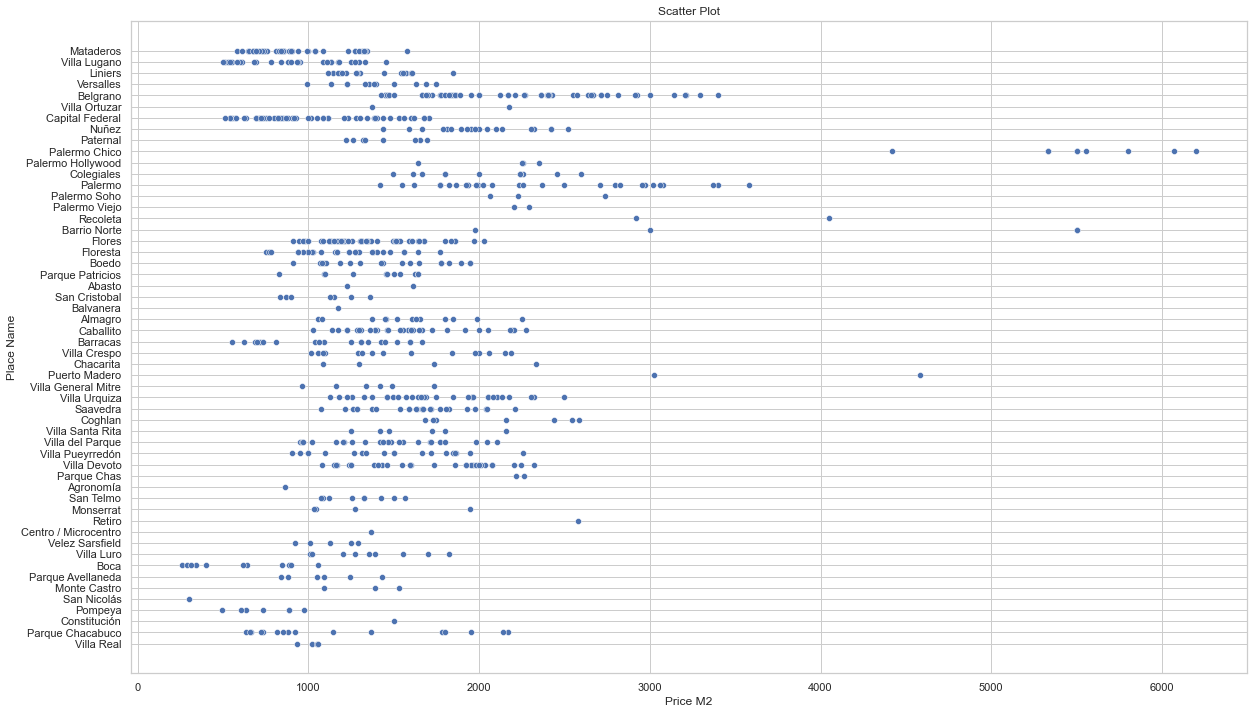

In [193]:
sns.set_style('whitegrid')
plt.figure(figsize = (20, 12))
sns.scatterplot(data = df_prop3[df_prop3['property_type']=='house'], x = "price_m2", y = "place_name")
plt.xlabel("Price M2"); plt.ylabel("Place Name");plt.title("Scatter Plot")
plt.show()

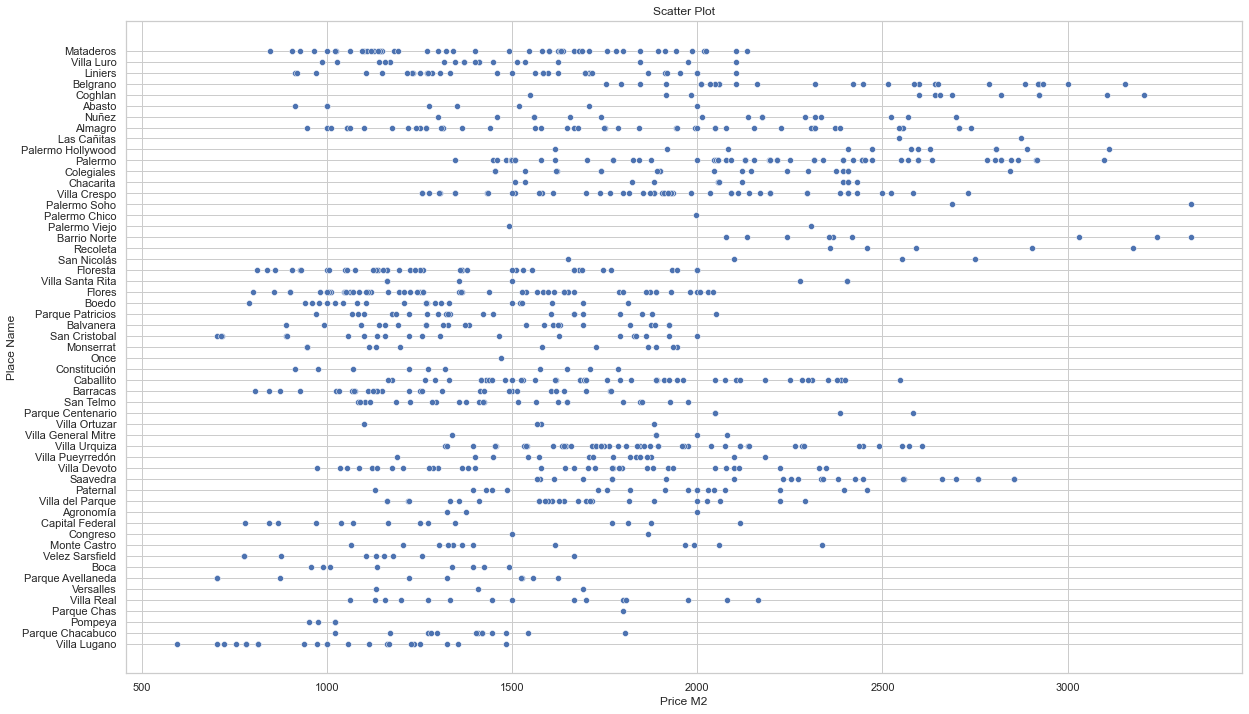

In [194]:
sns.set_style('whitegrid')
plt.figure(figsize = (20, 12))
sns.scatterplot(data = df_prop3[df_prop3['property_type']=='PH'], x = "price_m2", y = "place_name")
plt.xlabel("Price M2"); plt.ylabel("Place Name");plt.title("Scatter Plot")
plt.show()

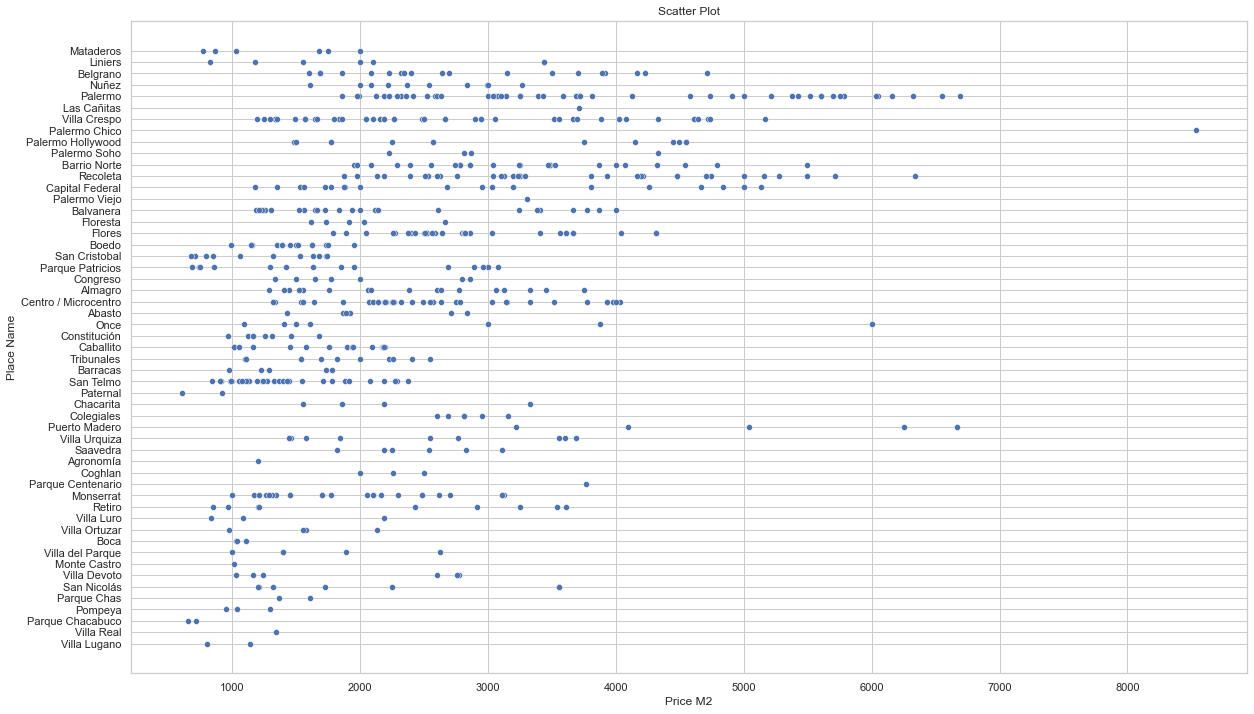

In [195]:
sns.set_style('whitegrid')
plt.figure(figsize = (20, 12))
sns.scatterplot(data = df_prop3[df_prop3['property_type']=='store'], x = "price_m2", y = "place_name")
plt.xlabel("Price M2"); plt.ylabel("Place Name");plt.title("Scatter Plot")
plt.show()

- Gráfico de dispersão do preço das propriedades tipo apartamento nos bairros

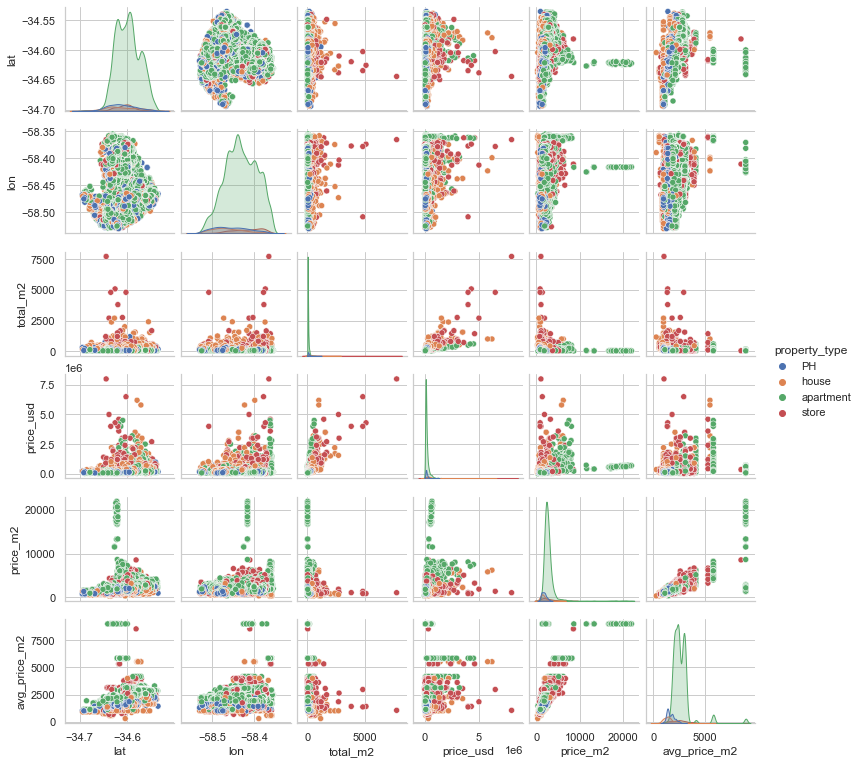

In [196]:
sns.pairplot(data = df_prop3[['property_type','place_name','lat','lon','total_m2','price_usd','price_m2','avg_price_m2']], hue = 'property_type', height = 1.8)

# Após a análise dos gráficos de correlação percebemos que há uma relação forte entre as colunas price_usd e total_m2.
 - Durante nossa etapa de limpeza e transformação optamos por criar uma coluna price_m2 que é a divisão entre o price_usd e o total_m2;
 - Sendo assim para nosso modelo de dados deixaremos as colunas float de price_m2 e avg_price_m2. A avg_price_m2 é uma média dos preços por property_type e place_name. Entendemos que ela possa servir como um indicador para auxiliar o machine learning a entender a variação de preços por property_type e place_name;
 - Criaremos abaixo as variáveis dummies por property_type e place_name.

# Dummy da variável tipo de propriedade 

- Criação de um novo df_prop5 com as coluna property_place e o preço m2

In [197]:
df_prop3.head(3)

property_type place_name country_name       state_name        lat  \
0             PH  Mataderos    Argentina  Capital Federal -34.661824   
4             PH  Mataderos    Argentina  Capital Federal -34.652356   
48            PH  Mataderos    Argentina  Capital Federal -34.657242   

          lon     price currency  total_m2  price_usd     price_m2  \
0  -58.508839   62000.0      USD      55.0    62000.0  1127.272727   
4  -58.501624  239000.0      USD     140.0   239000.0  1707.142857   
48 -58.502971   53000.0      USD      28.0    53000.0  1892.857143   

   property_place  count_place  avg_price_m2                     geometry  \
0    PH_Mataderos          164   1439.097374  POINT (-58.50884 -34.66182)   
4    PH_Mataderos          164   1439.097374  POINT (-58.50162 -34.65236)   
48   PH_Mataderos          164   1439.097374  POINT (-58.50297 -34.65724)   

    index_right NEIGHBORHOOD  COMMUNE     PERIMETER          AREA  
0            17    MATADEROS      9.0  11124.635792  7.398179e+06  
4            17    MATADEROS      9.0  11124.635792  7.398179e+06  
48           17    MATADEROS      9.0  11124.635792  7.398179e+06

In [198]:
df_prop5 = df_prop3.loc[:,["property_type","place_name","price_m2","avg_price_m2"]]

- verificando as primeiras linhas e quantidade registros

In [199]:
df_prop5.head(3)

property_type place_name     price_m2  avg_price_m2
0             PH  Mataderos  1127.272727   1439.097374
4             PH  Mataderos  1707.142857   1439.097374
48            PH  Mataderos  1892.857143   1439.097374

In [200]:
df_prop5.shape[0]

14860

- Criação Dummy Indicator columns para criar colunas fictícias para property_type, utilizamos drop_first para eliminar a primeira variável

In [201]:
df_prop5_dummy = pd.get_dummies(df_prop5, columns=['property_type'], prefix="type", prefix_sep="_", drop_first=False)

In [202]:
df_prop5_dummy.head(5)

place_name     price_m2  avg_price_m2  type_PH  type_apartment  \
0    Mataderos  1127.272727   1439.097374        1               0   
4    Mataderos  1707.142857   1439.097374        1               0   
48   Mataderos  1892.857143   1439.097374        1               0   
102  Mataderos  1100.000000   1439.097374        1               0   
178  Mataderos   743.243243    924.994468        0               0   

     type_house  type_store  
0             0           0  
4             0           0  
48            0           0  
102           0           0  
178           1           0

In [203]:
df_prop5_dummy = pd.get_dummies(df_prop5_dummy, columns=['place_name'], prefix="place", prefix_sep="_", drop_first=False)

In [204]:
df_prop5_dummy.head(5)

price_m2  avg_price_m2  type_PH  type_apartment  type_house  \
0    1127.272727   1439.097374        1               0           0   
4    1707.142857   1439.097374        1               0           0   
48   1892.857143   1439.097374        1               0           0   
102  1100.000000   1439.097374        1               0           0   
178   743.243243    924.994468        0               0           1   

     type_store  place_Abasto  place_Agronomía  place_Almagro  \
0             0             0                0              0   
4             0             0                0              0   
48            0             0                0              0   
102           0             0                0              0   
178           0             0                0              0   

     place_Balvanera  ...  place_Villa Devoto  place_Villa General Mitre  \
0                  0  ...                   0                          0   
4                  0  ...                   0                          0   
48                 0  ...                   0                          0   
102                0  ...                   0                          0   
178                0  ...                   0                          0   

     place_Villa Lugano  place_Villa Luro  place_Villa Ortuzar  \
0                     0                 0                    0   
4                     0                 0                    0   
48                    0                 0                    0   
102                   0                 0                    0   
178                   0                 0                    0   

     place_Villa Pueyrredón  place_Villa Real  place_Villa Santa Rita  \
0                         0                 0                       0   
4                         0                 0                       0   
48                        0                 0                       0   
102                       0                 0                       0   
178                       0                 0                       0   

     place_Villa Urquiza  place_Villa del Parque  
0                      0                       0  
4                      0                       0  
48                     0                       0  
102                    0                       0  
178                    0                       0  

[5 rows x 65 columns]

In [205]:
df_prop5_dummy.shape

(14860, 65)

# AQUI COMEÇA 

# Inclusão coluna com a distancia das propriedades até o obelisco

# Definindo as coordenadas do Obelisco

In [206]:
from shapely.geometry import Point
ponto_obelisco_p = Point(-58.381555, -34.605425)

In [207]:
type(ponto_obelisco_p)

shapely.geometry.point.Point

In [208]:
ponto_obelisco = (-58.381555, -34.605425)

In [209]:
type(ponto_obelisco)

tuple

Criação da coluna com a distancia até o obelisco no df_prop3

In [210]:
import geopy.distance

for i in df_prop3.index:
    df_prop3.loc[i, 'dist_obelisk'] = geopy.distance.geodesic(ponto_obelisco,
                                                                  (df_prop3.loc[i, 'geometry'].x ,df_prop3.loc[i, 'geometry'].y)
                                                                 ).meters

Observando as primeiras linhas do df_prop3

In [211]:
df_prop3.loc[:4, ['dist_obelisk', 'geometry', 'lat', 'lon','property_type', 'place_name']]

dist_obelisk                     geometry        lat        lon  \
0  14555.078219  POINT (-58.50884 -34.66182) -34.661824 -58.508839   
4  13651.907067  POINT (-58.50162 -34.65236) -34.652356 -58.501624   

  property_type place_name  
0            PH  Mataderos  
4            PH  Mataderos

Vizualização do pairplot com  nova coluna para ver se há correlação com as demais variáveis 

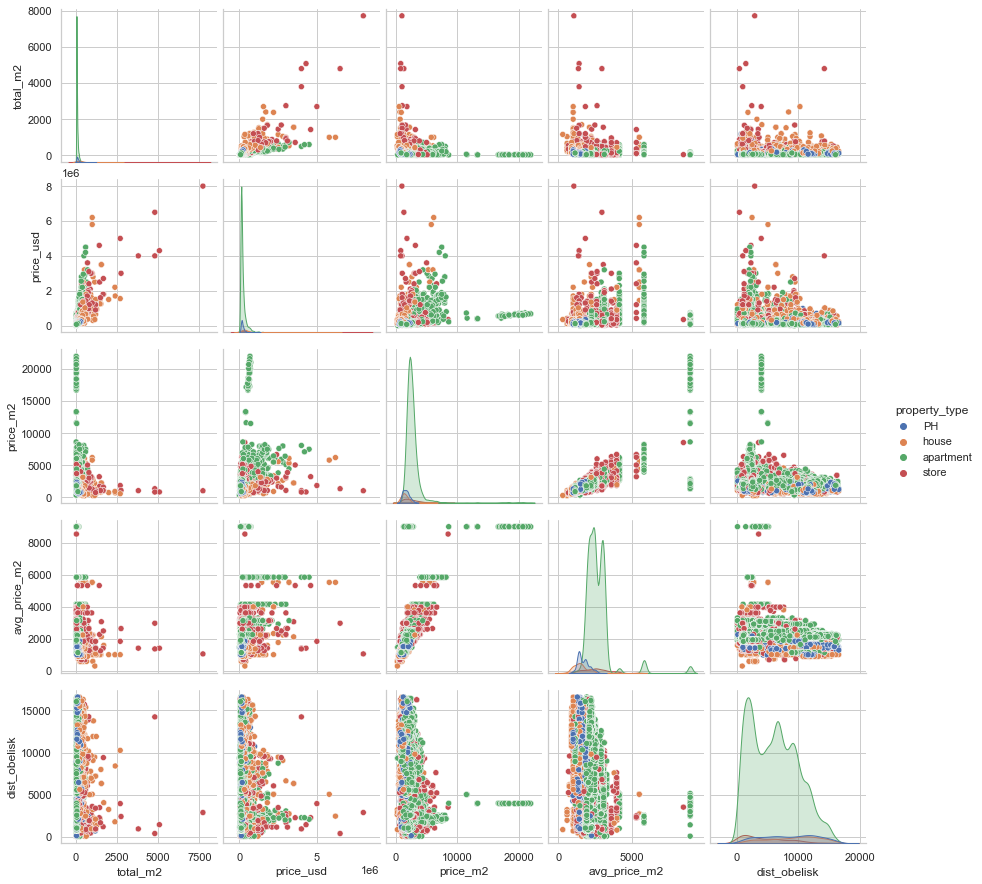

In [212]:
sns.pairplot(data = df_prop3[['property_type','total_m2','price_usd','price_m2','avg_price_m2','dist_obelisk']], hue = 'property_type');

Heatmap correlação

In [213]:
df_prop3_corr = df_prop3.loc[:,['place_name','total_m2','price_usd','price_m2','avg_price_m2','geometry','dist_obelisk']]
df_prop3_corr.head(5)

place_name  total_m2  price_usd     price_m2  avg_price_m2  \
0    Mataderos      55.0    62000.0  1127.272727   1439.097374   
4    Mataderos     140.0   239000.0  1707.142857   1439.097374   
48   Mataderos      28.0    53000.0  1892.857143   1439.097374   
102  Mataderos     150.0   165000.0  1100.000000   1439.097374   
178  Mataderos     222.0   165000.0   743.243243    924.994468   

                        geometry  dist_obelisk  
0    POINT (-58.50884 -34.66182)  14555.078219  
4    POINT (-58.50162 -34.65236)  13651.907067  
48   POINT (-58.50297 -34.65724)  13858.377659  
102  POINT (-58.48978 -34.65692)  12424.763096  
178  POINT (-58.49386 -34.65240)  12806.050820

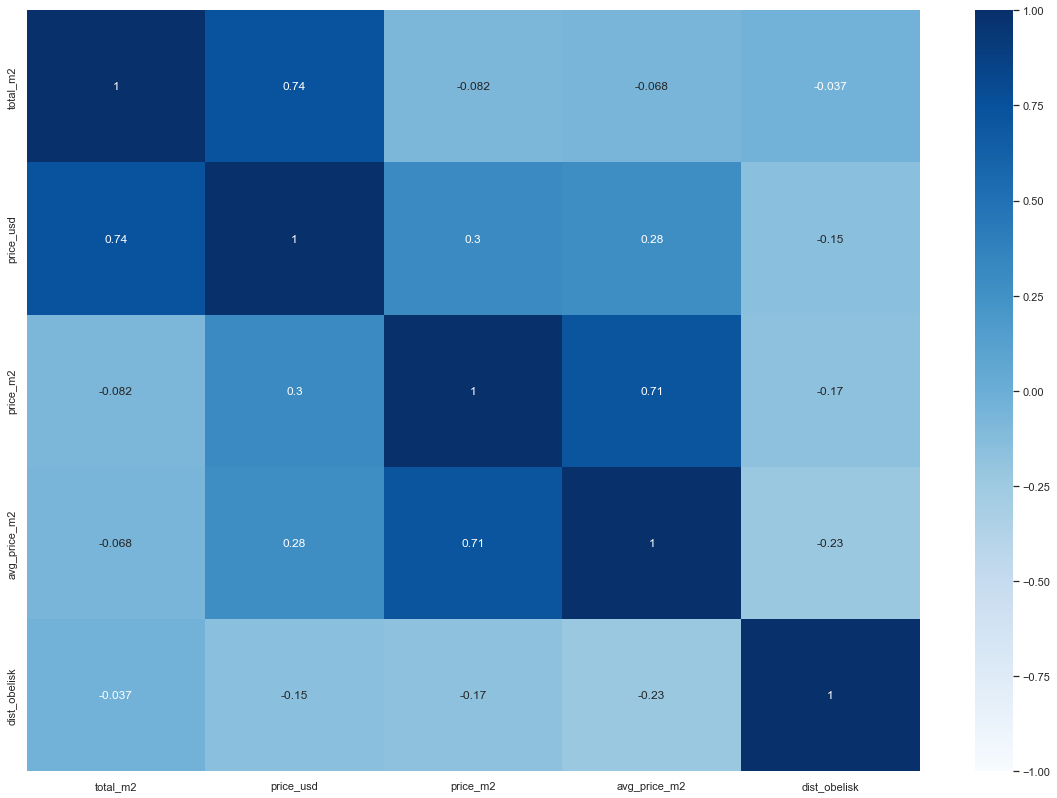

In [214]:
sns.heatmap(df_prop3_corr.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
           );

Observando se há padrões relevantes a olho nu entre a distancia e o preço m2 com scatterplot

In [215]:
df_prop3_corr = df_prop3.loc[:,['property_type','dist_obelisk','price_m2']]

In [216]:
df_prop3_corr.describe().T

count         mean          std         min          25%  \
dist_obelisk  14860.0  6353.790281  3990.667903   79.478551  2667.639101   
price_m2      14860.0  2565.178334  1436.977816  257.142857  1954.414838   

                      50%          75%           max  
dist_obelisk  6228.096084  9279.506164  16587.203391  
price_m2      2375.000000  2878.787879  21935.483871

# INICIO PROJETO PARTE II

# Segmentação dos dados para trabalhar com cerca de 2.000 registros

Observando a quantidade de propriedades por bairro

In [362]:
df_prop3.value_counts('place_name').head(10)

place_name
Caballito        1299
Belgrano         1264
Palermo          1231
Recoleta          851
Flores            785
Villa Crespo      703
Villa Urquiza     664
Almagro           640
Barrio Norte      633
San Telmo         430
dtype: int64

Segmentando o conjunto de dados por tipo de propriedade apartamento e features que serão utilizadas

In [363]:
mask = (df_prop3.property_type == "apartment") 
df_prop4 = df_prop3.loc[mask,['place_name','price_m2','total_m2','price_usd','avg_price_m2','dist_obelisk']]

Quantidade de registros do segmento de dados df_prop4

In [364]:
print(df_prop4.shape)

(12506, 6)


Criação de mascara para segmentar proprieddaes com preço por metro quadrado maior do que USD 3000.

In [365]:
mask_pricem2 = df_prop4.price_m2 >= 3000
df_prop4 = df_prop4.loc[mask_pricem2]

In [366]:
df_prop4.shape

(2876, 6)

In [368]:
df_prop4.value_counts('place_name', ascending=False).head(5)

place_name
Palermo          558
Belgrano         485
Recoleta         437
Puerto Madero    319
Barrio Norte     219
dtype: int64

Criação de mascara para segmentar os bairros que possuem mais do que 300 propriedades 

In [357]:
mask_count_place = df_prop4.count_place >= 300
df_prop4 = df_prop4.loc[mask_count_place]

Observando a quantidade de linhas e colunas do dataframe

In [358]:
df_prop4.shape

(1949, 7)

In [ ]:
Observando a quantidade de propriedades por bairro

In [344]:
df_prop4.value_counts('place_name')

place_name
Palermo          558
Belgrano         485
Recoleta         437
Puerto Madero    319
Barrio Norte     219
Caballito        127
Nuñez            105
Villa Urquiza     56
Villa Crespo      51
San Telmo         13
Almagro            3
dtype: int64

In [ ]:
Criação de uma nova coluna com a quantidade de propriedades por bairro

In [369]:
df_prop4['count_place2'] = df_prop4.groupby('place_name')['place_name'].transform('count')

Criaçãode uma máscara para segmentar por bairros com mais de 200 propriedades

In [371]:
mask_count_place2 = df_prop4.count_place2 >= 200
df_prop4 = df_prop4.loc[mask_count_place2]

In [373]:
print('Quantidade de linhas e colunas: ', df_prop4.shape)

Quantidade de linhas e colunas:  (2018, 7)


In [ ]:
Observando quais os bairros do dataframe

In [375]:
df_prop4.value_counts('place_name')

place_name
Palermo          558
Belgrano         485
Recoleta         437
Puerto Madero    319
Barrio Norte     219
dtype: int64

Observando a correlação entre as features

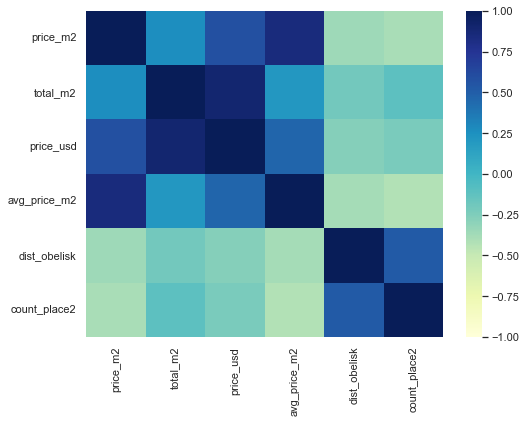

In [405]:
sns.heatmap(df_prop4.corr(), 
            vmin = -1, 
            vmax = 1, 
            center = 0, 
            cmap = "YlGnBu"
           );

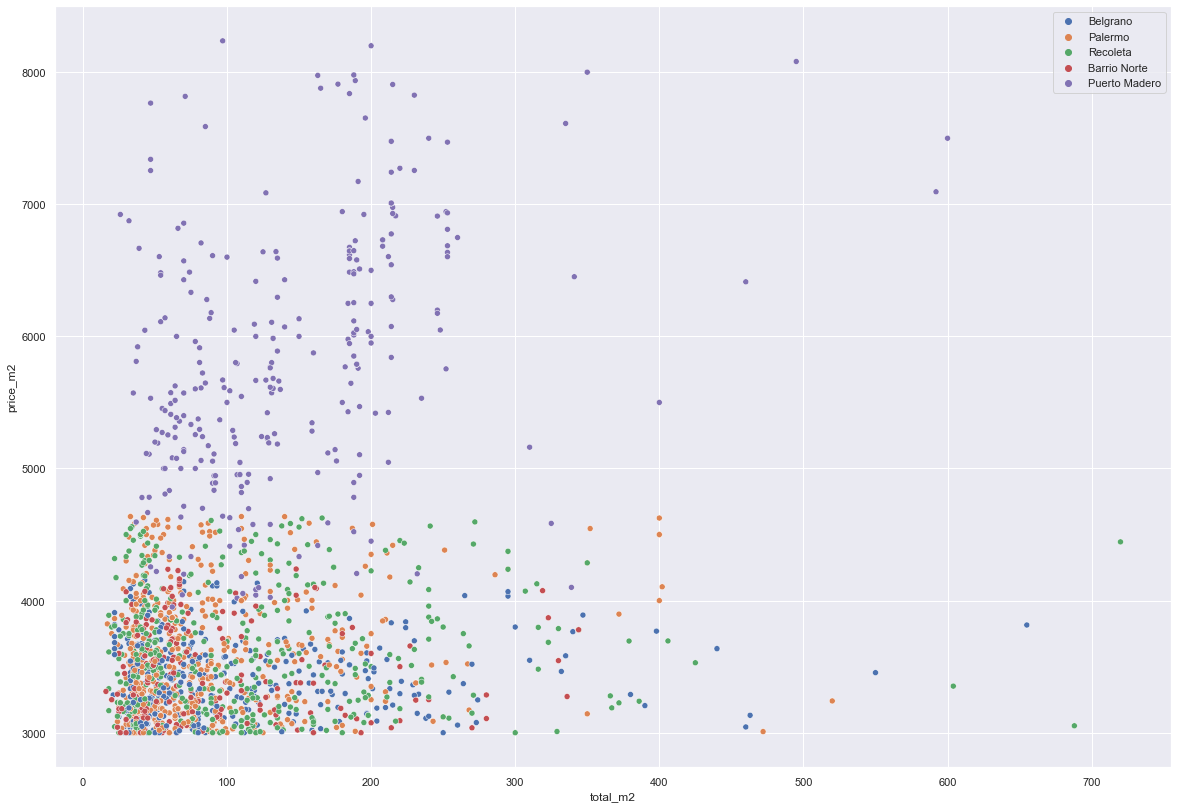

In [393]:
sns.set(style = "darkgrid")
sns.scatterplot(x = "total_m2", y = "price_m2", hue = df_prop4.place_name.tolist(), data = df_prop4)
plt.show()

# Normalização dos dados

In [377]:
df_prop4.head(5)

place_name     price_m2  total_m2  price_usd  avg_price_m2  dist_obelisk  \
2     Belgrano  3066.666667      45.0   138000.0   2921.082578   7381.316759   
3     Belgrano  3000.000000      65.0   195000.0   2921.082578   7381.316759   
31    Belgrano  3437.500000     160.0   550000.0   2921.082578   7996.173561   
158   Belgrano  3131.749460     463.0  1450000.0   2921.082578   8013.074455   
192   Belgrano  3418.333333      90.0   307650.0   2921.082578   7244.834506   

     count_place2  
2             485  
3             485  
31            485  
158           485  
192           485

In [ ]:
Normalização das colunas price_m2

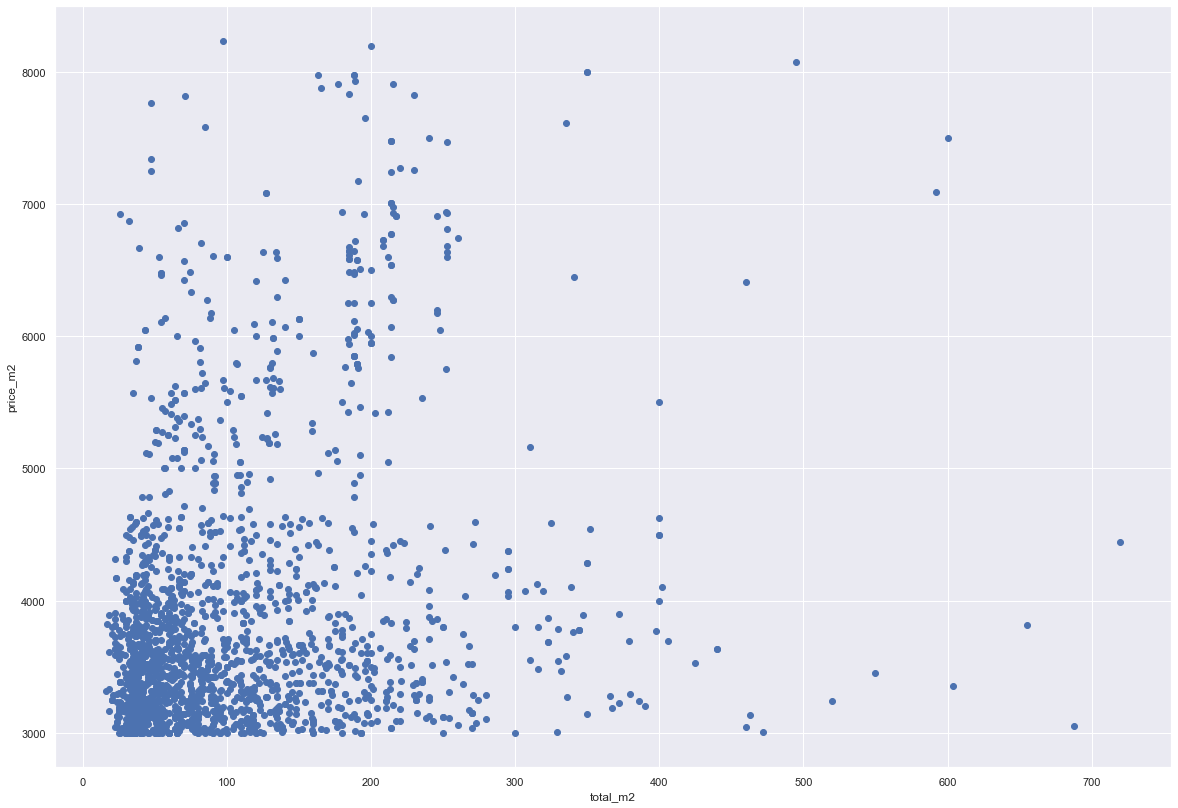

In [378]:
xs = df_prop4["total_m2"]
ys = df_prop4["price_m2"]

plt.scatter(xs, ys)
plt.xlabel("total_m2")
plt.ylabel("price_m2")
plt.show()

Observando os dados normalizados com o scikit-learn

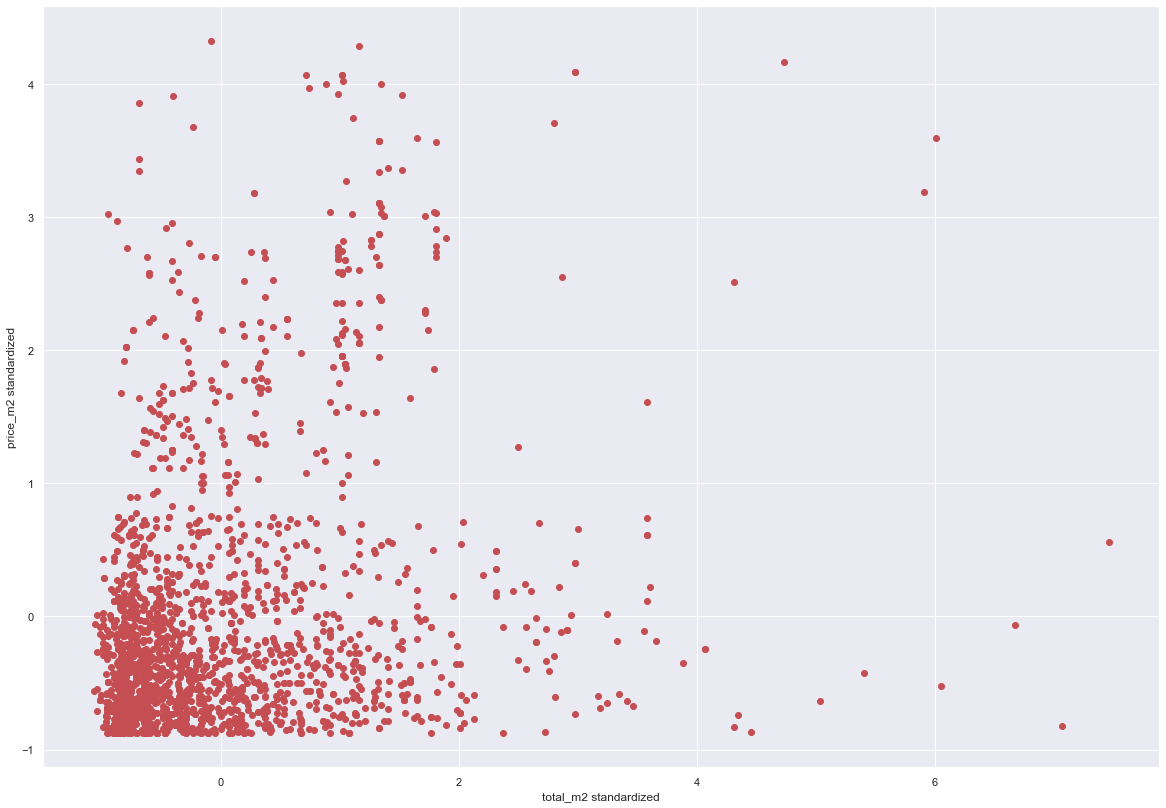

In [380]:
from sklearn import preprocessing

xs = preprocessing.scale(df_prop4["total_m2"])
ys = preprocessing.scale(df_prop4["price_m2"])

plt.scatter(xs, ys, color = 'r')
plt.xlabel("total_m2 standardized")
plt.ylabel("price_m2 standardized")
plt.show()

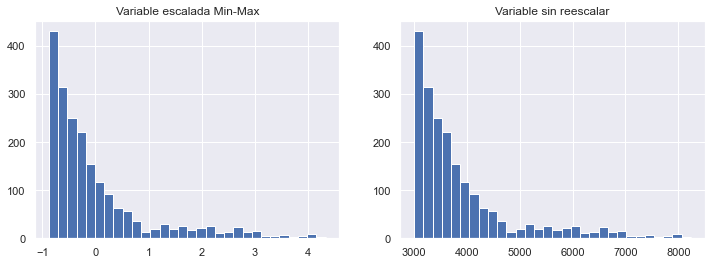

In [381]:
plt.figure(figsize = (12, 4))
ax1 = plt.subplot(121)
ax1.set_title("Variable escalada Min-Max")
ax1.hist(ys, bins = 30);

ax2 = plt.subplot(122)
ax2.set_title("Variable sin reescalar")
ax2.hist(df_prop4["price_m2"], bins = 30);

# Criação de um modelo de clustering não supervisionado a fim de  descobrir padrões ou estruturas subjacentes nas informações que nos permitam ter insights relevantes entre o total m2 e o preço m2

In [385]:
df_prop4_cluster1 = df_prop4.loc[:,['price_m2','total_m2']]

In [386]:
from sklearn.cluster import KMeans

In [387]:
kmeans = KMeans(n_clusters = 4)

In [388]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df_prop4_cluster1
X_scaled = scaler.fit_transform(X) # X_scaled são os dados transformados

In [389]:
kmeans.fit(X_scaled)

KMeans(n_clusters=4)

In [390]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

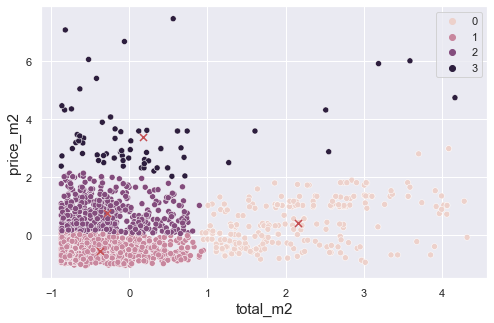

In [391]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = X_scaled[ : , 0 ], y = X_scaled[ : , 1 ], hue = labels, legend = 'full');
plt.xlabel('total_m2',fontsize = 15); plt.ylabel('price_m2', fontsize = 15);
plt.scatter(centroids[ : , 0 ], centroids[ : , 1 ], marker = 'x', s = 50, color = 'r');

# MODELO 1: REGRESSÃO LINEAR SIMPLES

Feature: total_m2
Target: price_m2

In [394]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16

In [398]:
df_prop4.head(5)

place_name     price_m2  total_m2  price_usd  avg_price_m2  dist_obelisk  \
2     Belgrano  3066.666667      45.0   138000.0   2921.082578   7381.316759   
3     Belgrano  3000.000000      65.0   195000.0   2921.082578   7381.316759   
31    Belgrano  3437.500000     160.0   550000.0   2921.082578   7996.173561   
158   Belgrano  3131.749460     463.0  1450000.0   2921.082578   8013.074455   
192   Belgrano  3418.333333      90.0   307650.0   2921.082578   7244.834506   

     count_place2  
2             485  
3             485  
31            485  
158           485  
192           485

In [399]:
type(df_prop4)

geopandas.geodataframe.GeoDataFrame

In [401]:
df_prop4 = pd.DataFrame(df_prop4)

In [402]:
type(df_prop4)

pandas.core.frame.DataFrame

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


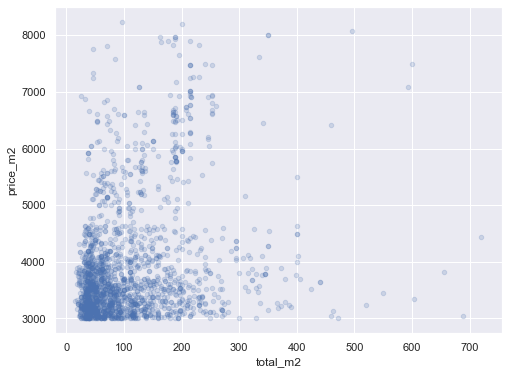

In [403]:
df_prop4.plot(kind = 'scatter', 
           x = 'total_m2', 
           y = 'price_m2', 
           alpha = 0.2
          );

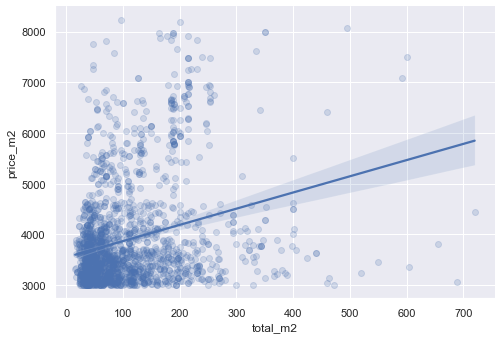

In [404]:
sns.lmplot(x = 'total_m2', 
           y = 'price_m2', 
           data = df_prop4, 
           aspect = 1.45,
           scatter_kws = {'alpha': 0.2}
          );